In [1]:
import csv
import datetime as dt
import math
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import animation
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures

## グラフの設定

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'  # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix'  # math fontの設定
plt.rcParams["font.size"] = 15  # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 9  # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 10  # 軸だけ変更されます
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in
plt.rcParams['axes.linewidth'] = 1.0  # axis line width
plt.rcParams['axes.grid'] = True  # make grid
plt.rcParams["legend.fancybox"] = False  # 丸角
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更
plt.rcParams["legend.handlelength"] = 1  # 凡例の線の長さを調節
plt.rcParams["legend.labelspacing"] = 0.  # 垂直方向（縦）の距離の各凡例の距離
plt.rcParams["legend.handletextpad"] = 1.  # 凡例の線と文字の距離の長さ
plt.rcParams["legend.markerscale"] = 2  # 点がある場合のmarker scale

# 数式はtex形式で
# r+$マークで囲いましょう。
# https://matplotlib.org/users/mathtext.html が参考になります。
# fig_1.set_xlabel(r"$x$")
# fig_1.set_ylabel(r"$y$")
# また、よくある軸を共有するやつは以下の感じでできます。
# 軸を共有させたい
# other_fig_1 = fig_1.twinx()
# other_fig_1.plot(x, y_2, label="test_2") # y_2は適当に作成したものです
# other_fig_1.set_ylabel(r"$y_{2}$")
# 軸の数字を斜めにする
# もできます。
# 以下コードを追加してください。
# fig_1.set_xticklabels(np.round(x, 2), rotation=30)

## 条件設定

In [3]:
# ハイドロフォン長さ
length_hp_m = 0.275
length_C_m = 0.5
pit_width = 0.2


event_marker_2018 = ['.','x', 'v', '1', 'D']

## データの読み込み、整理

In [4]:
# read a file
# インデックスをTIMESTANPに設定し，時系列データとして読み込む(index_col='TIMESTAMP', parse_dates=True)
df01 = pd.read_csv('logger1_2018-03-13_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv',
                   index_col='TIMESTAMP', parse_dates=True)
df02 = pd.read_csv('logger2_2018-03-13_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv',
                   index_col='TIMESTAMP', parse_dates=True)
df03 = pd.read_csv('logger3_2018-03-20_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv',
                   index_col='TIMESTAMP', parse_dates=True)
df04 = pd.read_csv('Precipitation_WL_Velocity201801to201812_every_1min.csv',
                   index_col='TIMESTAMP', parse_dates=True)
# print(df01,df02,df03,df04)

# read 2017file
df_2017 = pd.read_csv('Fukadani201607to201711.csv',
                      index_col='TIMESTAMP', parse_dates=True)

In [5]:
df_all = pd.concat([df01, df02, df03, df04], axis=1, sort=False)

# Load_Avgの差分をとる
df_all['Load_Avg_difference'] = df_all['Load_Avg'].diff()
df_2017['Load_Avg_difference'] = df_2017['Load_Avg'].diff()

# #NaNデータを削除
# df_all = df_all.dropna(how='any')

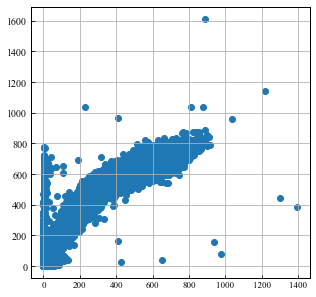

In [6]:
%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(df_all['hp_Tot(1)'], df_all['C_Tot(1)'])

In [7]:
# ハイドロフォンデータとピットデータをm-1に変える
colnames_of_hp = [i for i in df_all.columns if i.startswith('hp_Tot')]
colnames_of_C = [i for i in df_all.columns if i.startswith('C_Tot')]
colnames_of_RC = [i for i in df_all.columns if i.startswith('RC_Tot')]
colnames_of_R = [i for i in df_all.columns if i.startswith('R_Tot')]
colnames_of_LC = [i for i in df_all.columns if i.startswith('LC_Tot')]
colnames_of_L = [i for i in df_all.columns if i.startswith('L_Tot')]

colnames_of_RRCCLCL = colnames_of_R+colnames_of_RC + \
    colnames_of_C+colnames_of_LC+colnames_of_L
print(colnames_of_RRCCLCL)

df_all[colnames_of_hp] = df_all[colnames_of_hp]/length_hp_m
df_all[colnames_of_RRCCLCL] = df_all[colnames_of_RRCCLCL]/length_C_m

df_all['Load_Avg_difference'] = df_all['Load_Avg_difference']/pit_width

['R_Tot(1)', 'R_Tot(2)', 'R_Tot(3)', 'R_Tot(4)', 'R_Tot(5)', 'R_Tot(6)', 'R_Tot(7)', 'R_Tot(8)', 'R_Tot(9)', 'R_Tot(10)', 'RC_Tot(1)', 'RC_Tot(2)', 'RC_Tot(3)', 'RC_Tot(4)', 'RC_Tot(5)', 'RC_Tot(6)', 'RC_Tot(7)', 'RC_Tot(8)', 'RC_Tot(9)', 'RC_Tot(10)', 'C_Tot(1)', 'C_Tot(2)', 'C_Tot(3)', 'C_Tot(4)', 'C_Tot(5)', 'C_Tot(6)', 'C_Tot(7)', 'C_Tot(8)', 'C_Tot(9)', 'C_Tot(10)', 'LC_Tot(1)', 'LC_Tot(2)', 'LC_Tot(3)', 'LC_Tot(4)', 'LC_Tot(5)', 'LC_Tot(6)', 'LC_Tot(7)', 'LC_Tot(8)', 'LC_Tot(9)', 'LC_Tot(10)', 'L_Tot(1)', 'L_Tot(2)', 'L_Tot(3)', 'L_Tot(4)', 'L_Tot(5)', 'L_Tot(6)', 'L_Tot(7)', 'L_Tot(8)', 'L_Tot(9)', 'L_Tot(10)']


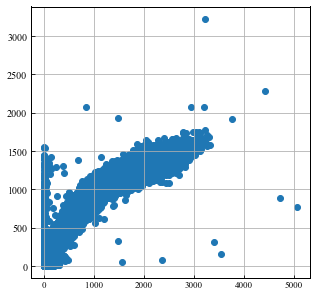

In [8]:
%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(df_all['hp_Tot(1)'], df_all['C_Tot(1)'])

In [7]:
# 縦横補正する
h, hp, l = 1, 1, 1

for i in range(1, 11):
    df_all['Rhv_right_Tot({})'.format(i)] = (
        df_all['VR_Tot({})'.format(i)]/h)/(df_all['R_Tot({})'.format(i)]/l)
    df_all['Rhv_left_Tot({})'.format(i)] = (
        df_all['VL_Tot({})'.format(i)]/h)/(df_all['L_Tot({})'.format(i)]/l)

    df_all['Corrected_with_right_Tot({})'.format(
        i)] = df_all['Rhv_right_Tot({})'.format(i)]*h/hp*df_all['C_Tot({})'.format(i)]
    df_all['Corrected_with_left_Tot({})'.format(
        i)] = df_all['Rhv_left_Tot({})'.format(i)]*h/hp*df_all['C_Tot({})'.format(i)]

# for i in range(1,11):
#     df_2017['Rhv_right_Tot({})'.format(i)] = (df_2017['VR_Tot({})'.format(i)]/h)/(df_2017['R_Tot({})'.format(i)]/l)
#     df_2017['Rhv_left_Tot({})'.format(i)] = (df_2017['VL_Tot({})'.format(i)]/h)/(df_2017['L_Tot({})'.format(i)]/l)

#     df_2017['Corrected_with_right_Tot({})'.format(i)] = df_2017['Rhv_right_Tot({})'.format(i)]*h/hp*df_2017['C_Tot({})'.format(i)]
#     df_2017['Corrected_with_left_Tot({})'.format(i)] = df_2017['Rhv_left_Tot({})'.format(i)]*h/hp*df_2017['C_Tot({})'.format(i)]

In [8]:
# name[1]にはスロット１のデータ、name[2]には、スロット２のデータ、name[3]に、、、が入っている
names = [0]*10
for j in range(1, 11):
    names[j-1] = [i for i in df_all.columns if '({})'.format(j) in i]

# Rhv_right_TotとCorrected_with_right_Totを削除
for i, name in enumerate(names):
    names[i] = name[:-4]

# （スロット１のデータ）−（スロット２のデータ）、（スロット２のデータ）－（スロット３のデータ）、、、としていき、
# 粒径ごとのデータに分類する
df_dia_2018 = [0]*10
for i in range(1, 10):
    df_dia_2018[i-1] = df_all[names[i-1]] - df_all[names[i]].values
df_dia_2018[9] = df_all[names[-1]]
    
# 全てのデータを繋げる
df_dia_all_2018 = pd.DataFrame()
for i in range(1, 10):
    df_dia_all_2018 = pd.concat([df_dia_all_2018, df_dia_2018[i-1]], axis=1)
df_dia_all_2018 = pd.concat([df_dia_all_2018, df_dia_2018[-1]], axis=1)

df_dia_all_2018['Load_Avg'] = df_all['Load_Avg']
df_dia_all_2018['Load_Avg_difference'] = df_all['Load_Avg_difference']

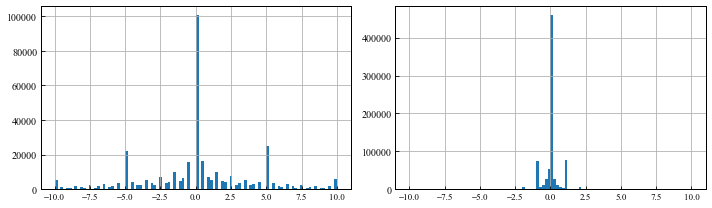

In [9]:
def histgram_of_Load_Avg_difference(df, num_bins=100, nums_range=(-10, 10)):
    # グラフが見きれないようにするためサイズを大きくしておく
    rcParams['figure.figsize'] = 5, 5
    # ヒストグラムを描画する(一括の時は単純にdf.hist())
    df['Load_Avg_difference'].hist(bins=num_bins, range=nums_range)


%matplotlib inline
plt.figure(figsize=(10, 3))
plt.subplot(121)
histgram_of_Load_Avg_difference(df_all)
plt.subplot(122)
histgram_of_Load_Avg_difference(df_2017)
# グラフ同士が重ならないようにする関数
plt.tight_layout()

Text(0, 0.5, 'Pit weight[kg]')

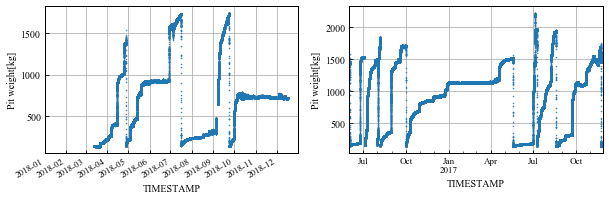

In [10]:
%matplotlib inline
plt.figure(figsize=(10, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.subplot(121)
df_all['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')
plt.subplot(122)
df_2017['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')

Text(0, 0.5, 'Pit weight[kg]')

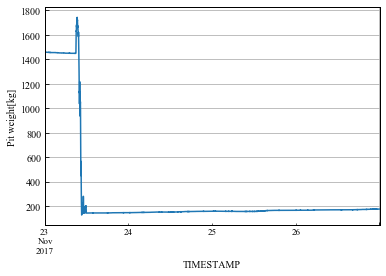

In [11]:
%matplotlib inline
df_2017['Load_Avg']["2017-11-23 0:00":"2017-12-24 0:00"].plot()
plt.ylabel('Pit weight[kg]')

In [12]:
# #イベント
# df_2017['Load_Avg']["2016-6-25 0:00":"2016-6-25 12:00"]
# df_2017['Load_Avg']["2016-7-05 0:00":"2016-7-30 0:00"]
# df_2017['Load_Avg']["2016-7-31 0:00":"2016-8-4 0:00"]
# df_2017['Load_Avg']["2016-8-30 5:00":"2016-8-30 20:00"]
# df_2017['Load_Avg']["2016-10-2 0:00":"2016-10-30 0:00"]
# df_2017['Load_Avg']["2016-12-12 0:00":"2016-12-29 0:00"]
# df_2017['Load_Avg']["2017-7-01 0:00":"2017-7-02 0:00"]
# df_2017['Load_Avg']["2017-7-09 0:00":"2017-8-8 0:00"]
# df_2017['Load_Avg']["2017-9-22 0:00":"2017-10-3 0:00"]
# df_2017['Load_Avg']["2017-10-22 12:00":"2017-10-23 12:00"]

# #除外イベント
# df_2017['Load_Avg']["2016-10-1 0:00":"2016-10-2 0:00"]
# df_2017['Load_Avg']["2017-11-23 0:00":"2017-11-24 0:00"]

In [13]:
# 2018年データの整理
# 4/28、7/26 9/4-6 9/23にピット掃除をしていそうだったのでデータを全部削除
# データに異常がみられる3/26,4/18を削除
# イベントがなく、じわじわピット内流砂が減少していた10/4以降を削除
sidxs = []
eidxs = []

sidxs.append('2018-04-28 0:00')
eidxs.append('2018-04-29 0:00')

sidxs.append('2018-07-16 0:00')
eidxs.append('2018-07-17 0:00')

sidxs.append('2018-09-04 0:00')
eidxs.append('2018-09-06 0:00')

sidxs.append('2018-09-23 0:00')
eidxs.append('2018-09-24 0:00')

sidxs.append('2018-03-26 0:00')
eidxs.append('2018-03-27 0:00')

sidxs.append('2018-04-18 0:00')
eidxs.append('2018-04-19 0:00')

sidxs.append('2018-10-04 0:00')
eidxs.append(df_all.index[-1])


for sidx, eidx in zip(sidxs, eidxs):
    drop_date_range = pd.date_range(sidx, eidx, freq='min')
    drop_date_range = drop_date_range & df_all.index
    df_all = df_all.drop(drop_date_range)
    df_dia_all_2018 = df_dia_all_2018.drop(drop_date_range)


# ピット差分が１０以上で、水平ハイドロフォンの６４倍が０のデータは全て消しました。
df_all = df_all[~((df_all['Load_Avg_difference'] >= 10)
                  & (df_all['hp_Tot(6)'] <= 3))]
#
df_dia_all_2018 = df_dia_all_2018[~(
    (df_dia_all_2018['Load_Avg_difference'] >= 10) & (df_dia_all_2018['hp_Tot(6)'] <= 3))]

In [14]:
# ２０１７年データの整理
# ピット掃除をしていそうだったのでデータを全部削除
sidxs = []
eidxs = []

sidxs.append("2016-10-1 0:00")
eidxs.append('2016-10-2 0:00')

sidxs.append("2017-11-23 0:00")
eidxs.append('2017-12-24 0:00')

# sidxs.append('2018-10-04 0:00')
# eidxs.append(df_all.index[-1])


for sidx, eidx in zip(sidxs, eidxs):
    drop_date_range = pd.date_range(sidx, eidx, freq='min')
    drop_date_range = drop_date_range & df_2017.index
    df_2017 = df_2017.drop(drop_date_range)

# Cut data where pit weigh < 1000?500?
df_2017['Load_Avg'] = df_2017['Load_Avg'].values.astype('float')
# df_2017 = df_2017[(df_2017['Load_Avg'] > 200)&(df_2017['Load_Avg'] < 1300)]

# Cut data where pit load difference is out of margin of error
df_2017 = df_2017[(df_2017['Load_Avg_difference'] < 20) &
                  (df_2017['Load_Avg_difference'] > -0.5)]

df_2017 = df_2017[~((df_2017['Load_Avg_difference'] > 5)
                    & (df_2017['hp_Tot(6)'] < 50))]

# ピット差分が１０以上で、水平ハイドロフォンの６４倍が1０以下のデータは全て消しました。
df_2017 = df_2017[~((df_2017['Load_Avg_difference'] >= 10)
                    & (df_2017['hp_Tot(6)'] <= 10))]

Text(0, 0.5, 'Pit weight[kg]')

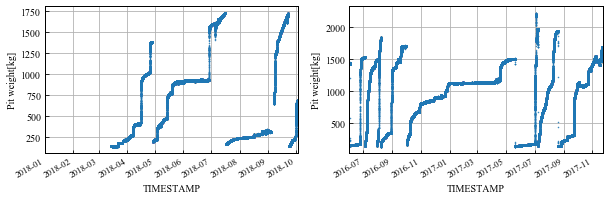

In [15]:
%matplotlib inline
plt.figure(figsize=(10, 3))
plt.subplot(121)
df_all['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')
plt.subplot(122)
df_2017['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')

In [16]:
sum_interval = 30

df_sum_2018 = df_all.resample('{}T'.format(sum_interval)).sum() / sum_interval
df_sum_2018['Load_Avg'] = df_all['Load_Avg']
df_sum_2018['Load_Avg_difference'] = df_all['Load_Avg_difference'].resample(
    '{}T'.format(sum_interval)).sum() / sum_interval

df_sum_2017 = df_2017.resample('{}T'.format(sum_interval)).sum() / sum_interval
df_sum_2017['Load_Avg'] = df_2017['Load_Avg']
df_sum_2017['Load_Avg_difference'] = df_2017['Load_Avg_difference'].resample(
    '{}T'.format(sum_interval)).sum() / sum_interval

df_sum_dia_2018 = df_dia_all_2018.resample(
    '{}T'.format(sum_interval)).sum() / sum_interval
df_sum_dia_2018['Load_Avg'] = df_dia_all_2018['Load_Avg']
df_sum_dia_2018['Load_Avg_difference'] = df_dia_all_2018['Load_Avg_difference'].resample(
    '{}T'.format(sum_interval)).sum() / sum_interval
# mavgs = 3
# temp_X_cols = df1[X_cols].rolling(window=mavgs).mean()
# temp_y_cols = df1[y_cols].rolling(window=mavgs).mean()


# df1.dropna(how='any')

Text(0, 0.5, 'Pit weight[kg]')

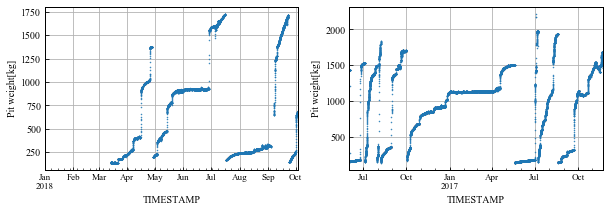

In [17]:
%matplotlib inline
plt.figure(figsize=(10, 3))
plt.subplot(121)
df_sum_2018['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')
plt.subplot(122)
df_sum_2017['Load_Avg'].plot(ls='none', marker='.', markersize=1)
plt.ylabel('Pit weight[kg]')

In [18]:
# moving averages
# Setting a rate of moving averages
mavgs = 3
df_movingav_2018 = df_all.rolling(mavgs).mean()
# # NaNデータを削除
# df_movingav_2018 = df_movingav_2018.dropna(how='any')


df_movingav_2017 = df_2017.rolling(mavgs).mean()
# # NaNデータを削除
# df_movingav_2017 = df_movingav_2017.dropna(how='any')

## データの切り替え

In [19]:
# 使うデータを切り替える（sumなのか、moving averageなのか、２０１７年なのか２０１８年なのか）
#####################
# year = "2017"
year = "2018"
process = "sum"
# process = "sum_dia"
# process = "movingav"
#####################
list_of_processes = ["df_movingav_2017", "df_movingav_2018",
                     "df_sum_2017", "df_sum_2018", "df_sum_dia_2018"]

# 使うデータを絞り込む
list_name = [s for s in list_of_processes if year in s]
print(list_name)
list_name = [s for s in list_name if process in s]
print(list_name)
# 使うデータをdf_finと名付けて以下使う
df_fin = eval(list_name[0])

['df_movingav_2018', 'df_sum_2018', 'df_sum_dia_2018']
['df_sum_2018', 'df_sum_dia_2018']


## ピット内重量ごとにデータを分けてグラフを描く

In [20]:
def cut_by_pit_value(x, y, df):
    '''
    x：ピットの下限
    y：ピットの上限
    df：df_finを入れればいい

    ピット内重量がx以上y以下のデータのみを取り出す
    '''
    df_cut = df[(df['Load_Avg'] > x) & (df['Load_Avg'] < y)]
    return df_cut

In [21]:
# ピット内が０～２００kg,２００～４００kg,２００～４００kg.......１４００～１６００kgの時を取り出す
df_fin_cut = [0]*8
for i in range(len(df_fin_cut)):
    df_fin_cut[i] = cut_by_pit_value(i*200, (i+1)*200, df_fin)

In [22]:
print(df_fin.columns)

Index(['Unnamed: 0', 'RECORD', 'Bat_Avg', 'Pit_WL_Avg', 'L_UR_Avg', 'L_UL_Avg',
       'L_DR_Avg', 'L_DL_Avg', 'Load_Avg', 'WL_FMR_Avg',
       ...
       'Corrected_with_right_Tot(8)', 'Corrected_with_left_Tot(8)',
       'Rhv_right_Tot(9)', 'Rhv_left_Tot(9)', 'Corrected_with_right_Tot(9)',
       'Corrected_with_left_Tot(9)', 'Rhv_right_Tot(10)', 'Rhv_left_Tot(10)',
       'Corrected_with_right_Tot(10)', 'Corrected_with_left_Tot(10)'],
      dtype='object', length=185)


In [23]:
# スロットナンバーと倍率を対応させる
amplification_factor = {'hp_Tot(1)': '1024', 'hp_Tot(2)': '512', 'hp_Tot(3)': '256', 'hp_Tot(4)': '128',
                        'hp_Tot(5)': '64', 'hp_Tot(6)': '32', 'hp_Tot(7)': '16', 'hp_Tot(8)': '8',
                        'hp_Tot(9)': '4', 'hp_Tot(10)': '2'}

In [24]:
def make_graphs_from_1to10():
    if process == "sum_dia":
        range_max = 11
    else:
        range_max = 11
    num_of_amplification = None
    for i in range(1, range_max):
        x_name = "Load_Avg_difference"
        y_name = "hp_Tot({})".format(i)
        num_of_amplification = amplification_factor[y_name]
        # ファイルの保存先
        save_dir = './scatter_gparhs_by_pit_fill_rate/'
        # max(max(nums1, nums2, key=max))
        %matplotlib inline
        ylim = max(df_fin_cut[0][y_name].max(), df_fin_cut[1][y_name].max(), df_fin_cut[2][y_name].max(),
                   df_fin_cut[3][y_name].max(), df_fin_cut[4][y_name].max())
        xlim = max(df_fin_cut[0][x_name].max(), df_fin_cut[1][x_name].max(), df_fin_cut[2][x_name].max(),
                   df_fin_cut[3][x_name].max(), df_fin_cut[4][x_name].max())
        margin = ylim/20

        print(ylim, xlim, margin)

        fig = plt.figure(figsize=(10, 10))
        for i in range(len(df_fin_cut)):
            x = df_fin_cut[i][x_name]
            y = df_fin_cut[i][y_name]
            plt.subplot(331 + i)
            plt.title("{0}to{1}".format(i*200, (i+1)*200))
            plt.scatter(x, y, marker='.')
            plt.xlim(-1, xlim+0.5)
            plt.ylim(-margin, ylim + margin)
            plt.ylabel('Pusles[min-1]' + '(' + num_of_amplification + ')')
            plt.xlabel('Bedload discharge[kg m-1 min-1]')

        plt.subplot(339)
        plt.title("200-1000")
        for i in range(1, 5):
            x = df_fin_cut[i][x_name]
            y = df_fin_cut[i][y_name]
            plt.scatter(x, y, marker='.')
            plt.xlim(-1, xlim+0.5)
            plt.ylim(-margin, ylim + margin)
            plt.ylabel('Pusles[min-1]' + '(' + num_of_amplification + ')')
            plt.xlabel('Bedload discharge[kg m-1 min-1]')

        fig.tight_layout()
        # 名前をつけて保存
        plt.savefig(os.path.join(save_dir, y_name + year + "_" +
                                 process), bbox_inches="tight", pad_inches=0.05)

2071.6363636363635 13.866666666666655 103.58181818181818
1860.4848484848483 13.866666666666655 93.02424242424242
1497.575757575757 13.866666666666655 74.87878787878785
1085.9393939393942 13.866666666666655 54.29696969696971
884.3636363636364 13.866666666666655 44.21818181818182
616.2424242424242 13.866666666666655 30.812121212121212
438.9090909090908 13.866666666666655 21.94545454545454
280.8484848484849 13.866666666666655 14.042424242424243
155.87878787878785 13.866666666666655 7.793939393939392
52.36363636363636 13.866666666666655 2.618181818181818


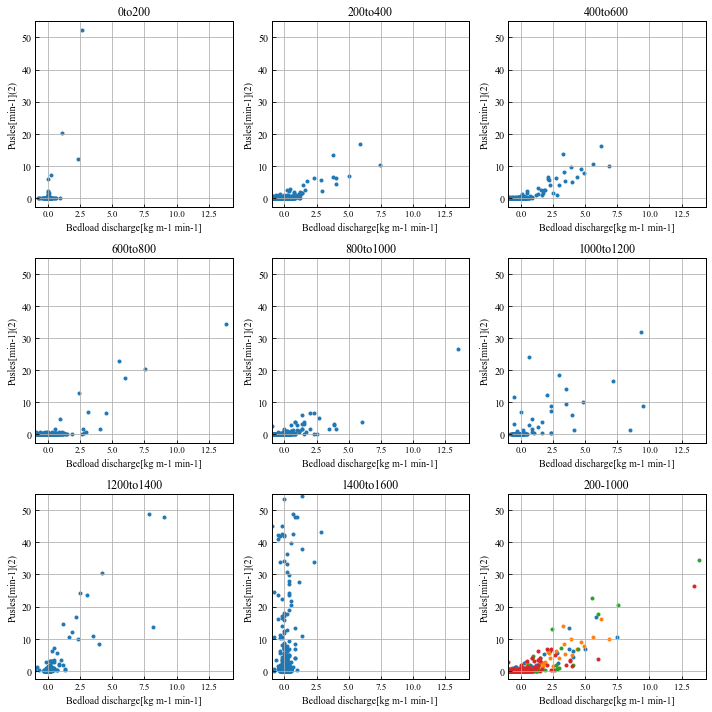

In [25]:
make_graphs_from_1to10()

In [26]:
# 使うcolumnデータを選択。x_nameは基本"Load_Avg_difference"
x_name = "Load_Avg_difference"
y_name = "hp_Tot(6)"

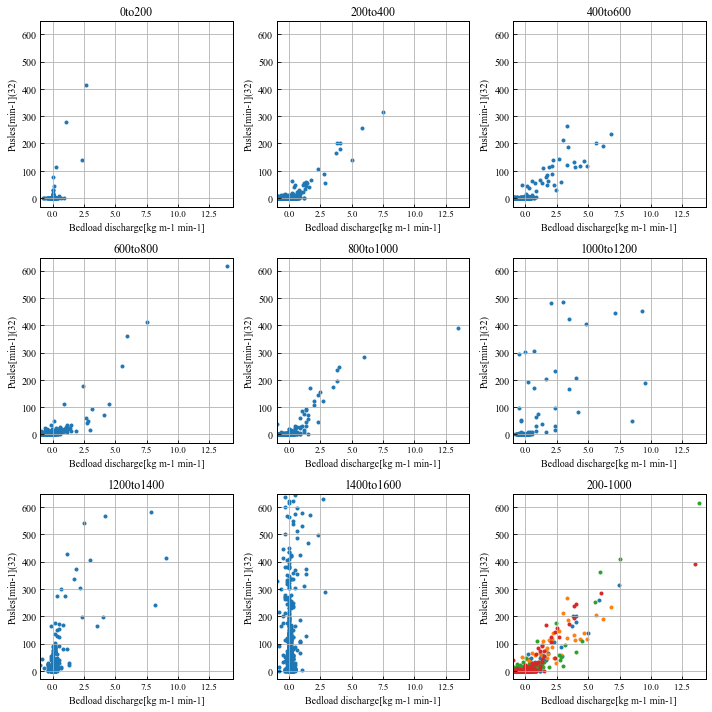

In [27]:
# ファイルの保存先
save_dir = './scatter_gparhs_by_pit_fill_rate/'
num_of_amplification = amplification_factor[y_name]

%matplotlib inline
ylim = max(df_fin_cut[0][y_name].max(), df_fin_cut[1][y_name].max(), df_fin_cut[2][y_name].max(),
           df_fin_cut[3][y_name].max(), df_fin_cut[4][y_name].max())
xlim = max(df_fin_cut[0][x_name].max(), df_fin_cut[1][x_name].max(), df_fin_cut[2][x_name].max(),
           df_fin_cut[3][x_name].max(), df_fin_cut[4][x_name].max())
margin = ylim/20

fig = plt.figure(figsize=(10, 10))
# plt.ylabel('Pusles[min-1]'+ '(' + num_of_amplification + ')')
# plt.xlabel('Bedload discharge[kg m-1min-1]')
for i in range(len(df_fin_cut)):
    x = df_fin_cut[i][x_name]
    y = df_fin_cut[i][y_name]
    plt.subplot(331 + i)
    plt.title("{0}to{1}".format(i*200, (i+1)*200))
    plt.scatter(x, y, marker='.')
    plt.xlim(-1, xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]' + '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg m-1 min-1]')

plt.subplot(339)
plt.title("200-1000")
for i in range(1, 5):
    x = df_fin_cut[i][x_name]
    y = df_fin_cut[i][y_name]
    plt.scatter(x, y, marker='.')
    plt.xlim(-1, xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]' + '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg m-1 min-1]')


fig.tight_layout()
# 名前をつけて保存
plt.savefig(os.path.join(save_dir, y_name + year + "_" + process),
            bbox_inches="tight", pad_inches=0.05)

## イベントごとに抽出して分布図を見る

In [28]:
if year == "2018":
    df_event_num = [0]*3
    # event No. 1: 2018年4月15日 0:00－16日 0:00  24h
    # event No. 2: 2018年4月24日18:00－25日18:00  24h
    # event No. 3: 2018年6月28日 6:00－28日18:00  12h
    # event No. 4: 2018年9月 8日 0:00－16日12:00  372h
    # event No. 5: 2018年9月30日21:00－10月1日3:00 6h
    df_event_num[0] = df_fin['2018-04-15 0:00': '2018-04-16 0:00']
    df_event_num[1] = df_fin['2018-09-08 0:00': '2018-09-16 12:00']
    df_event_num[2] = df_fin['2018-09-30 21:00': '2018-10-1 6:00']
    # #df_event_no5['Rhv_right_Tot(5)']になぜかinfやNanがあり、あとでグラフが書けなくなったからとりあえず０で穴埋め。
    # df_event_no5 = df_event_no5.replace([np.inf, -np.inf], np.nan)
    # df_event_no5 = df_event_no5.fillna(0)
    df_event_num[1] = df_event_num[1]['2018-09-08 0:00': '2018-09-08 8:00']

    event_color_2018 = ['b', 'g', 'r', 'c', 'm']
elif year == '2017':
    df_event_num = [0]*10
    df_event_num[0] = df_2017['Load_Avg']["2016-6-25 0:00":"2016-6-25 12:00"]
    df_event_num[1] = df_2017['Load_Avg']["2016-7-05 0:00":"2016-7-30 0:00"]
    df_event_num[2] = df_2017['Load_Avg']["2016-7-31 0:00":"2016-8-4 0:00"]
    df_event_num[3] = df_2017['Load_Avg']["2016-8-30 5:00":"2016-8-30 20:00"]
    df_event_num[4] = df_2017['Load_Avg']["2016-10-2 0:00":"2016-10-30 0:00"]
    df_event_num[5] = df_2017['Load_Avg']["2016-12-12 0:00":"2016-12-29 0:00"]
    df_event_num[6] = df_2017['Load_Avg']["2017-7-01 0:00":"2017-7-02 0:00"]
    df_event_num[7] = df_2017['Load_Avg']["2017-7-09 0:00":"2017-8-8 0:00"]
    df_event_num[8] = df_2017['Load_Avg']["2017-9-22 0:00":"2017-10-3 0:00"]
    df_event_num[9] = df_2017['Load_Avg']["2017-10-22 12:00":"2017-10-23 12:00"]

    event_color_2018 = ['b', 'g', 'r', 'c', 'm', ]

In [29]:
len(df_event_num)

3

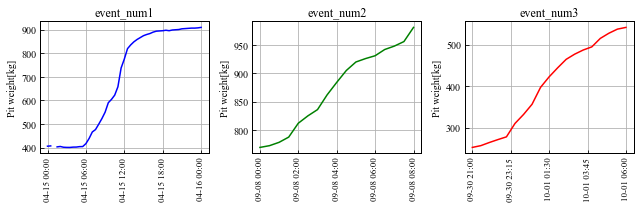

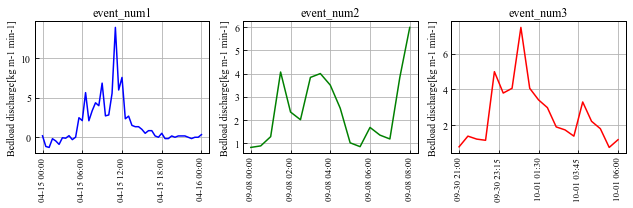

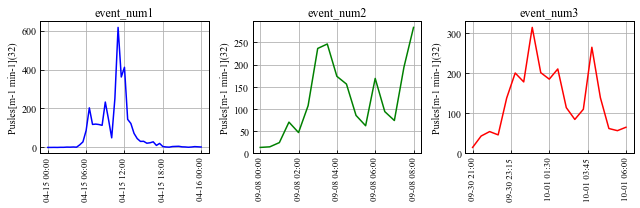

In [30]:
def make_time_series_graphs_of_five_events(column_name='Load_Avg'):

    fig = plt.figure(figsize=(9, 3))
    for i in range(1, len(df_event_num)+1):
        ax = plt.subplot(130+i)
        ax.set_title('event_num{}'.format(i))
        ax.plot(df_event_num[i-1][column_name], color=event_color_2018[i-1])

        # x-Axis locations of 5 timestamps
        ts_loc = pd.to_datetime(np.linspace(
            df_event_num[i-1].index[0].value, df_event_num[i-1].index[-1].value, 5))
        f = "%m-%d %H:%M"
        ts_loc_without_year = ts_loc.strftime(f)
        ax.set_xticks(ts_loc, minor=False)

        # Names of the timestamps (only last shown)
        ts_names = ts_loc_without_year
        ax.set_xticklabels(ts_names, rotation="vertical")

        if column_name == 'Load_Avg':
            plt.ylabel('Pit weight[kg]')
        elif 'Load_Avg_difference' in column_name:
            plt.ylabel('Bedload discharge[kg m-1 min-1]')
        elif 'Tot' in column_name:
            num_of_amplification = amplification_factor[column_name]
            plt.ylabel('Pusles[m-1 min-1]' + '(' + num_of_amplification + ')')
        else:
            plt.ylabel('Worning!Imputted Unknown data.')

    fig.tight_layout()
    save_dir_seminers = './graphs_for_seminers/'
    plt.savefig(os.path.join(save_dir_seminers, column_name +
                             'time_series_graph' + year + process + str(len(df_event_num)) + 'events'))


%matplotlib inline
make_time_series_graphs_of_five_events('Load_Avg')
make_time_series_graphs_of_five_events('Load_Avg_difference')
make_time_series_graphs_of_five_events(y_name)

In [31]:
# イベント１～５まで結合
df_123 = pd.concat(df_event_num, sort=False)

In [32]:
# ピット内が０～２００kg,２００～４００kg,２００～４００kg.......１４００～１６００kgの時を取り出す
df_123_cut = [0]*8
for i in range(len(df_123_cut)):
    df_123_cut[i] = cut_by_pit_value(i*200, (i+1)*200, df_123)

In [33]:
def make_graphs_3events_Tot_from_1to10():

    if process == "sum_dia":
        range_max = 10
    else:
        range_max = 11
    num_of_amplification = None
    for i in range(1, range_max):
        y_name = "hp_Tot({})".format(i)
        x_name = "Load_Avg_difference"
        num_of_amplification = amplification_factor[y_name]
#         x_name = "C_Tot({})".format(i)

        save_dir = './scatter_gparhs_by_pit_fill_rate/'

        fig = plt.figure(figsize=(10, 10))
        plt.title("correlation" + y_name + "_" + x_name)

        ylim = max(df_123[y_name])
        xlim = max(df_123[x_name])
        margin = ylim/20

        for i in range(len(df_123_cut)):
            x = df_123_cut[i][x_name]
            y = df_123_cut[i][y_name]
            plt.subplot(331 + i)
            plt.title("{0}to{1}".format(i*200, (i+1)*200))
            plt.scatter(x, y, marker='.')
            plt.xlim(-1, xlim+0.5)
            plt.ylim(-margin, ylim + margin)
            plt.ylabel('Pusles[min-1]' + '(' + num_of_amplification + ')')
            plt.xlabel('Bedload discharge[kg m-1 min-1]')
        plt.subplot(339)
        plt.title("200-1200")
        for i in range(1, 6):
            x = df_123_cut[i][x_name]
            y = df_123_cut[i][y_name]
            plt.scatter(x, y, marker='.')
            plt.xlim(-1, xlim+0.5)
            plt.ylim(-margin, ylim + margin)
            plt.ylabel('Pusles[min-1]' + '(' + num_of_amplification + ')')
            plt.xlabel('Bedload discharge[kg m-1 min-1]')

        fig.tight_layout()
        plt.savefig(os.path.join(save_dir, y_name + "2018_3events" +
                                 "_" + process + str(len(df_event_num)) + 'events'))

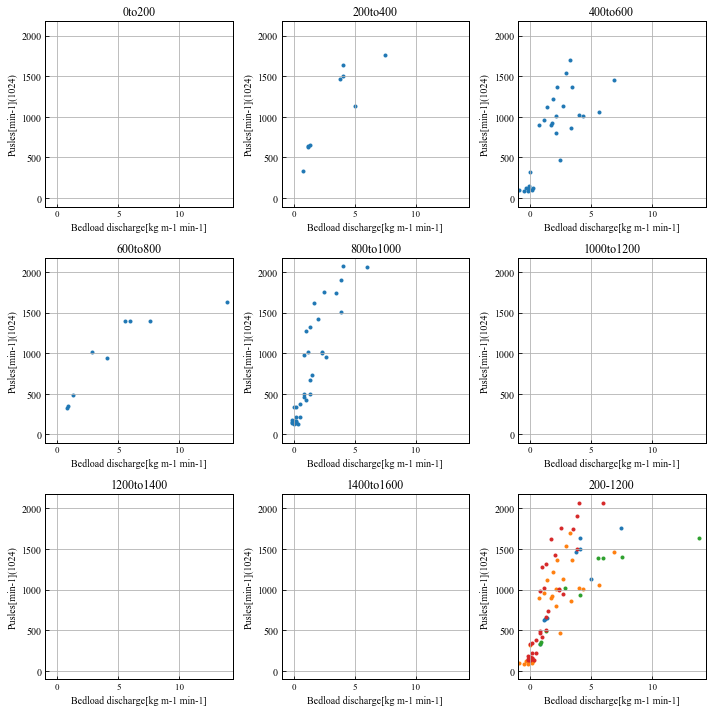

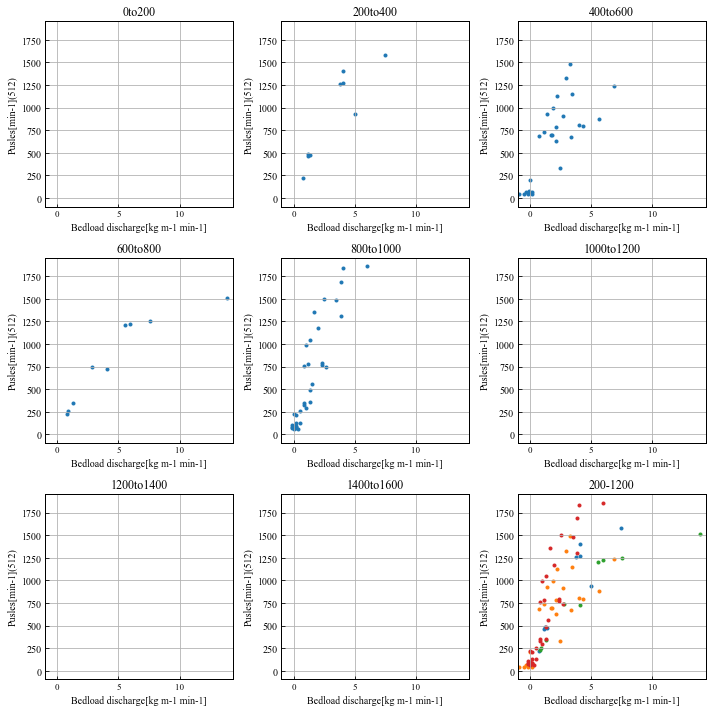

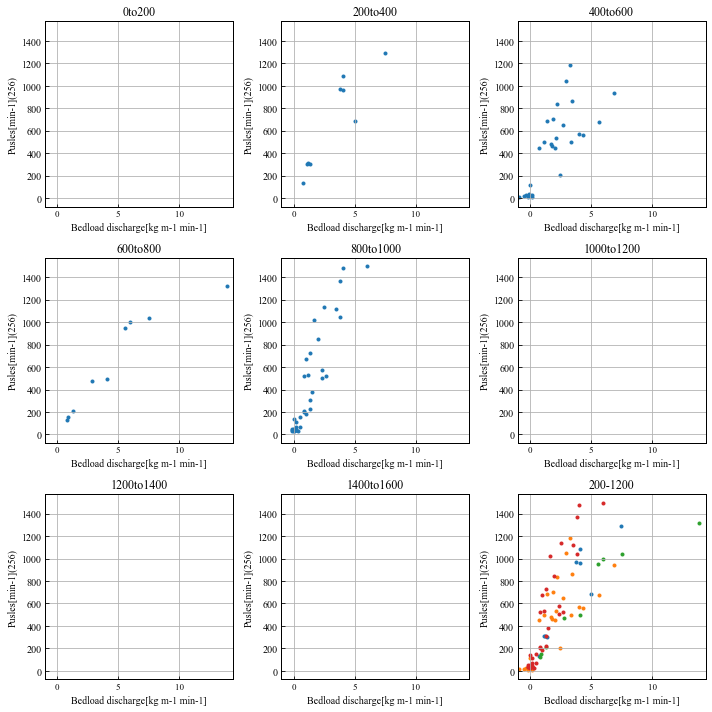

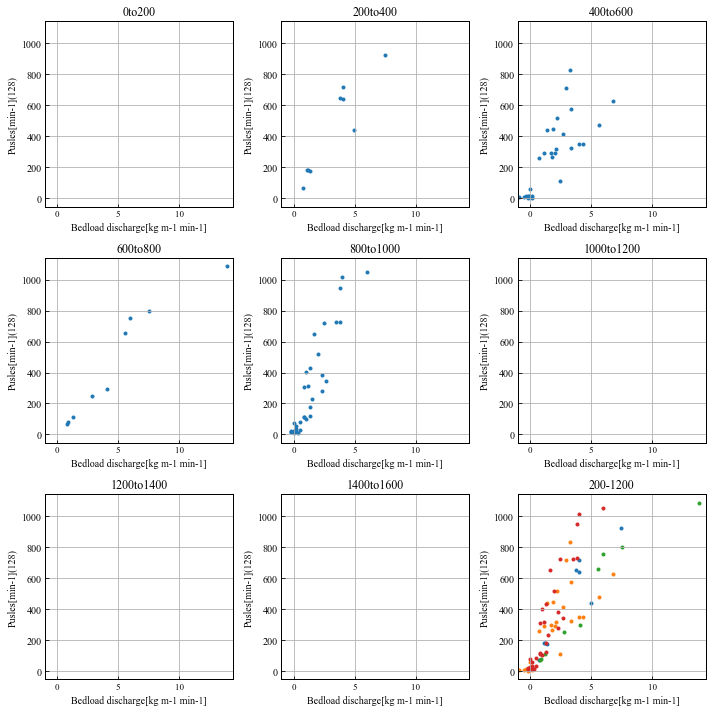

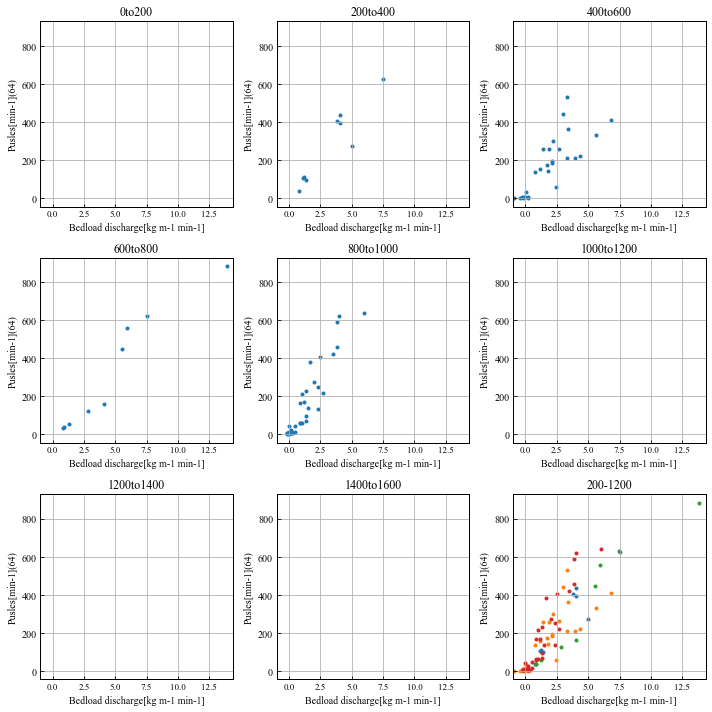

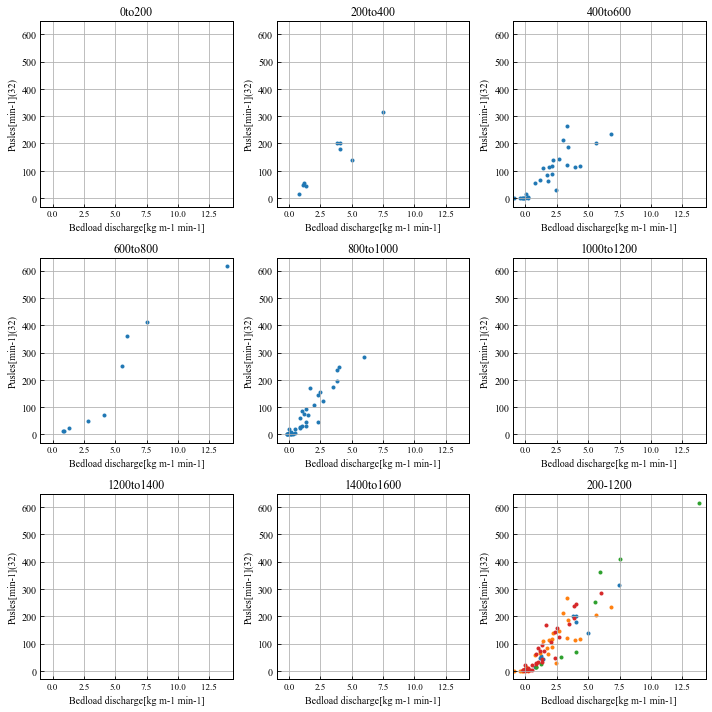

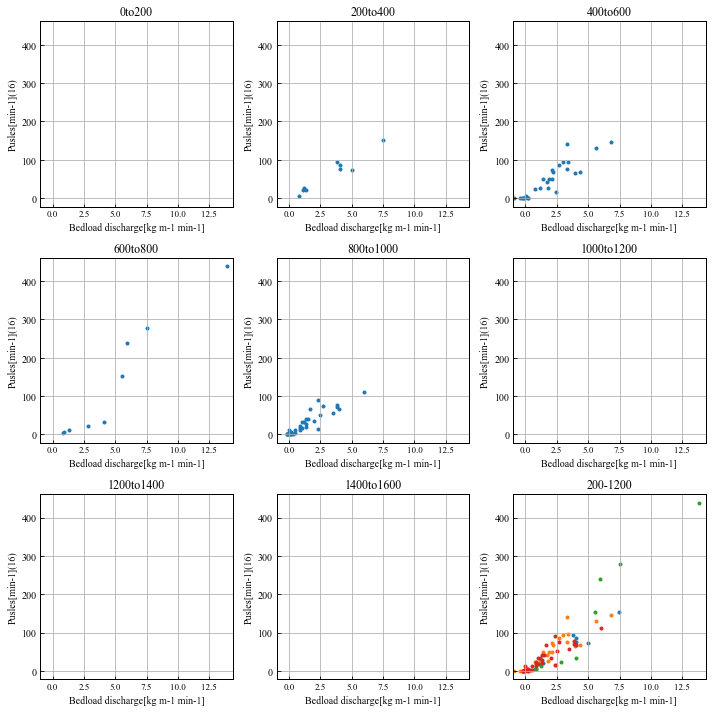

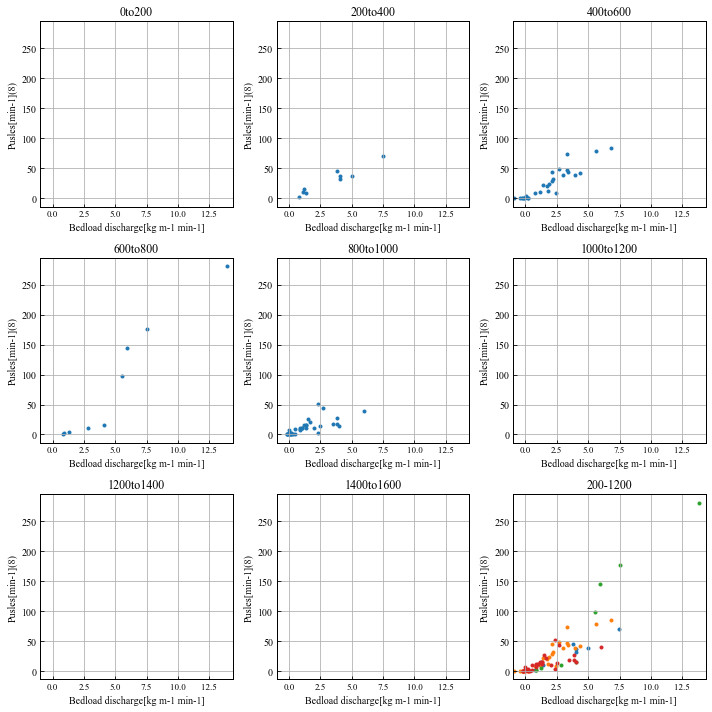

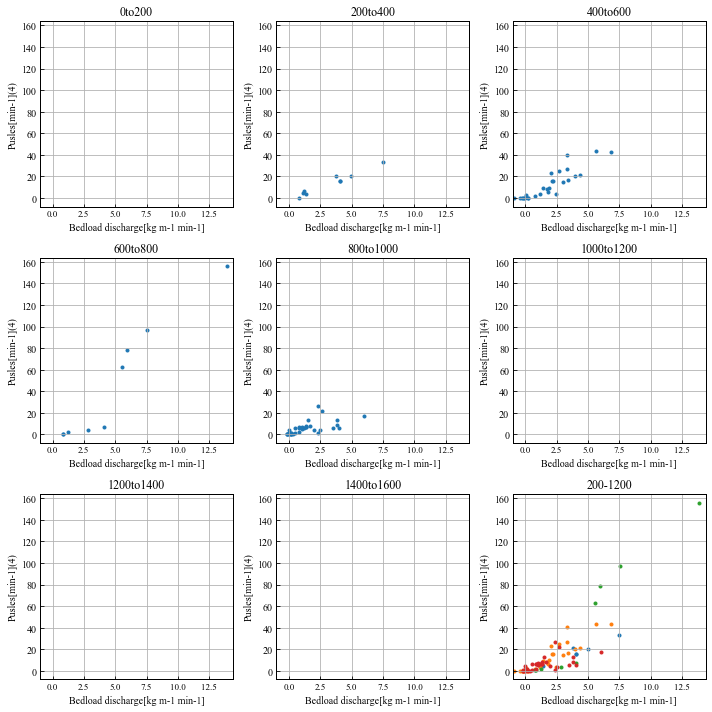

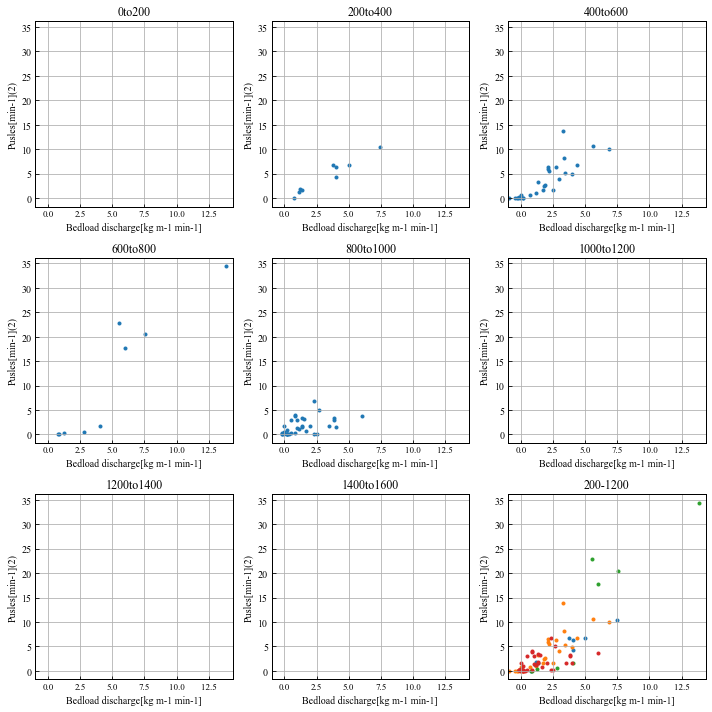

In [34]:
make_graphs_3events_Tot_from_1to10()

In [35]:
# 使うcolumnデータを選択。x_nameは基本"Load_Avg_difference"
x_name = "Load_Avg_difference"
y_name = "hp_Tot(6)"
slot_num = 6

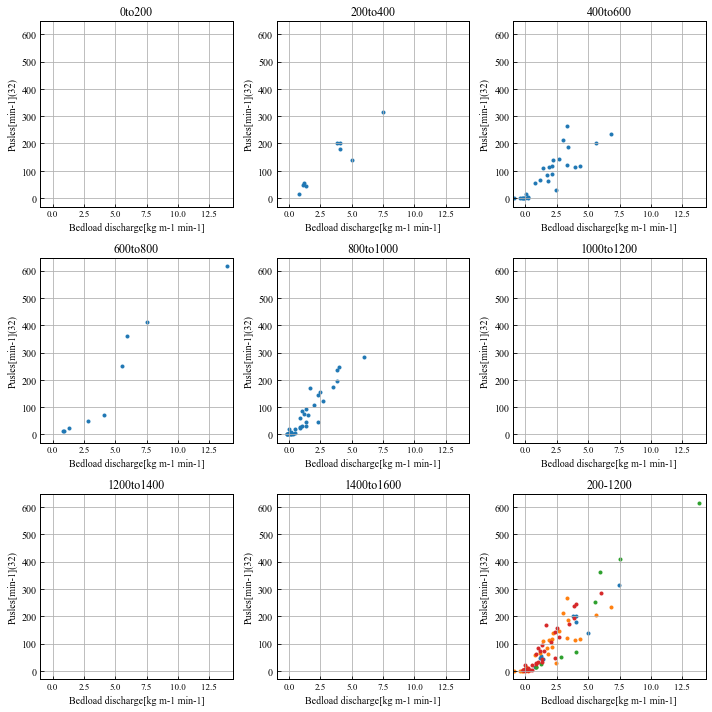

In [36]:
save_dir = './scatter_gparhs_by_pit_fill_rate/'
num_of_amplification = amplification_factor[y_name]


%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ylim = max(df_123[y_name])
xlim = max(df_123[x_name])
margin = ylim/20

for i in range(len(df_123_cut)):
    x = df_123_cut[i][x_name]
    y = df_123_cut[i][y_name]
    plt.subplot(331 + i)
    plt.title("{0}to{1}".format(i*200, (i+1)*200))
    plt.scatter(x, y, marker='.')
    plt.xlim(-1, xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]' + '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg m-1 min-1]')

plt.subplot(339)
plt.title("200-1200")
for i in range(1, 7):
    x = df_123_cut[i][x_name]
    y = df_123_cut[i][y_name]
    plt.scatter(x, y, marker='.')
    plt.xlim(-1, xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[min-1]' + '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg m-1 min-1]')

fig.tight_layout()
plt.savefig(os.path.join(save_dir, y_name + "2018_3events" +
                         "_" + process + str(len(df_event_num)) + 'events'))

In [37]:
for i in range(len(df_event_num)):
    df_event_num[i] = cut_by_pit_value(0, 1200, df_event_num[i])

In [38]:
# イベント１～５まで結合
df_123 = pd.concat(df_event_num, sort=False)

In [39]:
# 使うcolumnデータを選択。x_nameは基本"Load_Avg_difference"
x_name = "Load_Avg_difference"
y_name = "hp_Tot(6)"

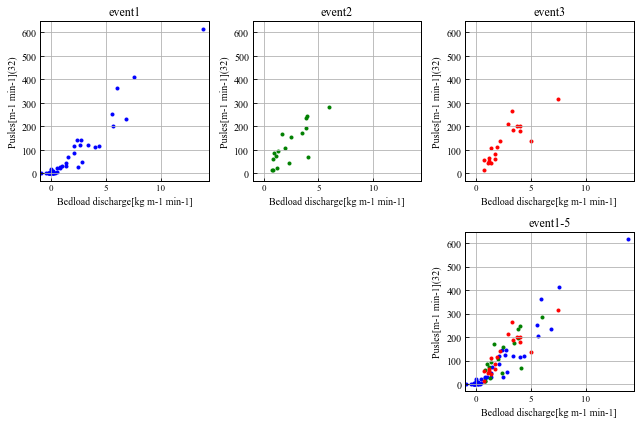

In [40]:
save_dir_seminers = './graphs_for_seminers/'
num_of_amplification = amplification_factor[y_name]

%matplotlib inline
fig = plt.figure(figsize=(9, 6))
ylim = max(df_123[y_name])
xlim = max(df_123[x_name])
margin = ylim/20

for i in range(len(df_event_num)):
    x = df_event_num[i][x_name]
    y = df_event_num[i][y_name]
    plt.subplot(231 + i)
    plt.title("event{0}".format(i+1))
    plt.scatter(x, y, marker='.', color=event_color_2018[i])
    plt.xlim(-1, xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[m-1 min-1]' + '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg m-1 min-1]')

plt.subplot(236)
plt.title("event1-5")
for i in range(len(df_event_num)):
    x = df_event_num[i][x_name]
    y = df_event_num[i][y_name]
    plt.scatter(x, y, marker='.', color=event_color_2018[i])
    plt.xlim(-1, xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[m-1 min-1]' + '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg m-1 min-1]')

fig.tight_layout()
plt.savefig(os.path.join(save_dir_seminers, y_name + "2018_3events" +
                         "_" + process + str(len(df_event_num)) + 'events'))

## 相関関数を決め、流砂量予測。さらに、実測値と比較

In [41]:
# 使うcolumnデータを選択。x_nameは基本"Load_Avg_difference"
x_name = "Load_Avg_difference"
y_name = "hp_Tot(6)"
slot_num = int(re.sub(r'\D', '', y_name))
num_of_amplification = amplification_factor[y_name]

In [42]:
print(slot_num)

6


In [43]:
# 重み付き最小二乗法（単純な最小2乗法ではない）
def linear_regression(df_X, df_Y, color='r'):
    """
    X:input of x ax(example:x_cols)
    Y:input of y ax(example:x_cols)
    """
    # fit_intercept	False に設定すると切片を求める計算を含めない。
    # 目的変数が原点を必ず通る性質のデータを扱うときに利用。 (デフォルト値: True)
    clf = linear_model.LinearRegression(fit_intercept=False)

    X = df_X.values.reshape(-1, 1)
    Y = df_Y.values.reshape(-1, 1)
    clf.fit(X, Y)
    y_hat = clf.predict(X)

    # 近似直線との誤差を計算する
    diff = Y - y_hat

    # 近似直線との誤差が、比較的が大きい点を無視するような、sample_weightを作成する
    sample_weight = (np.max(np.abs(diff)) - np.abs(diff)
                     ).astype('float32').T[0] ** 2

    # scikit-learnのsolverに、sample_weightを与えて、近似直線を得る
    # 詳しくは"https://medium.com/micin-developers/decipher-github-lr-sw-40e519a13c0a"
    clf.fit(X, Y, sample_weight=sample_weight)
#     y_hat    = clf.predict(X)

#     # 近似直線との誤差を計算する（再）
#     diff     = y - y_hat


#     #傾きをレジェンド表記
#     print(clf.intercept_)
# 　レジェンドに切片を含める
#     label_slope= "slope:" + str(round(clf.coef_.flatten()[0],1)) + \
#                             "\n" + "intercept:" + str(round(clf.intercept_,1)) + \
#                             "\n" + "R^2:" + str(round(clf.score(X, Y).flatten()[0],1))
# 　レジェンドに切片を含めない（切片０だから）
#     print("R^2=",clf.score(X, Y))
    label_slope = "slope:" + str(round(clf.coef_.flatten()[0], 2)) + \
        "\n" + "R^2:" + str(round(clf.score(X, Y), 2))

#     print("切片：",clf.intercept_)
#     plt.scatter(X, Y)
    # 回帰直線
    plt.plot(X, clf.predict(X), label=label_slope, c=color)
    plt.legend()

    return clf.coef_.flatten()[0]

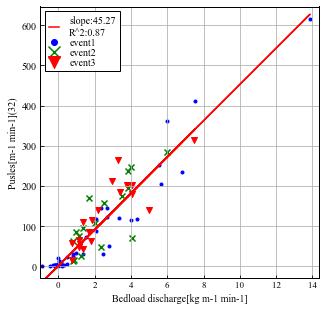

In [44]:
save_dir_seminers = './graphs_for_seminers/'

%matplotlib inline
plt.figure(figsize=(5, 5))
slope = linear_regression(df_123[x_name], df_123[y_name])
ylim = max(df_123[y_name])
xlim = max(df_123[x_name])
margin = ylim/20
for i in range(len(df_event_num)):
    x = df_event_num[i][x_name]
    y = df_event_num[i][y_name]
    plt.scatter(x, y, color=event_color_2018[i], marker=event_marker_2018[i],label='event{}'.format(i+1))
    plt.xlim(-1, xlim+0.5)
    plt.ylim(-margin, ylim + margin)
    plt.ylabel('Pusles[m-1 min-1]' + '(' + num_of_amplification + ')')
    plt.xlabel('Bedload discharge[kg m-1 min-1]')
    plt.legend()

plt.savefig(os.path.join(save_dir_seminers, "linear_regression" +
                         y_name + process + str(len(df_event_num)) + 'events'))

In [45]:
print("Y = " + str(round(slope,3)) + "X")

Y = 45.272X


In [46]:
for i in range(len(df_event_num)):
    df_event_num[i]["sediment discharge_calc"] = df_event_num[i][y_name] / slope

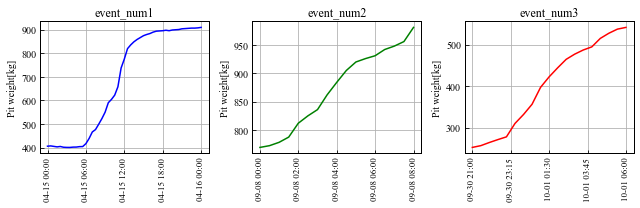

In [47]:
make_time_series_graphs_of_five_events('Load_Avg')

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


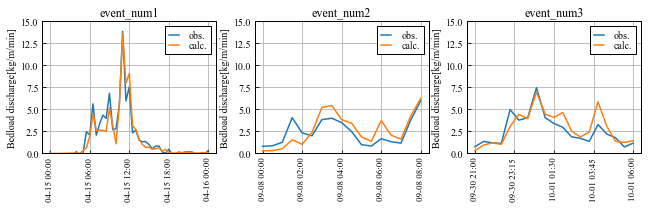

In [48]:
%matplotlib inline
fig = plt.figure(figsize=(9, 3))
for i, df in enumerate(df_event_num):
    df["sediment_discharge_calc"] = df[y_name] / slope

    ax = plt.subplot(131+i)
    ax.set_title('event_num{}'.format(i+1))
    ax.plot(df['Load_Avg_difference'], label='obs.')
    ax.plot(df['sediment_discharge_calc'], label='calc.')
    plt.legend()
    plt.ylabel('Bedload discharge[kg/m/min]')

    # x-Axis locations of 5 timestamps
    ts_loc = pd.to_datetime(np.linspace(
        df.index[0].value, df.index[-1].value, 5))
    f = "%m-%d %H:%M"
    ts_loc_without_year = ts_loc.strftime(f)
    ax.set_xticks(ts_loc, minor=False)

    # Names of the timestamps (only last shown)
    ts_names = ts_loc_without_year
    ax.set_xticklabels(ts_names, rotation="vertical")

    ax.set_ylim(0, 15)


fig.tight_layout()
plt.savefig(os.path.join(save_dir_seminers,
                         'comparison_of_Load_Avg_difference_btw_obs_and_calc' + str(len(df_event_num)) + 'events'))
fig.show()

2398.4999999999995   2302.046538452457   0.9597859238909557
1230.0   1357.6130702345927   1.1037504636053599
1478.9999999999995   1648.7022766320702   1.1147412282840234


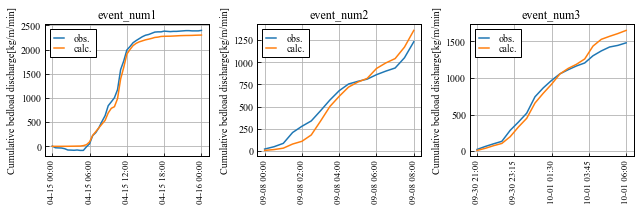

In [49]:
fig = plt.figure(figsize=(9, 3))
for i, df in enumerate(df_event_num):
    df["sediment_discharge_cumsum_calc"] = df["sediment_discharge_calc"].cumsum() * \
        sum_interval
    df["sediment_discharge_cumsum_obs"] = df["Load_Avg_difference"].cumsum() * \
        sum_interval

    ax = plt.subplot(131+i)
    plt.title('event_num{}'.format(i+1))
    ax.plot(df["sediment_discharge_cumsum_obs"], label='obs.')
    ax.plot(df['sediment_discharge_cumsum_calc'], label='calc.')
    plt.legend()
    plt.ylabel('Cumulative bedload discharge[kg/m/min]')
    
    # x-Axis locations of 5 timestamps
    ts_loc = pd.to_datetime(np.linspace(
        df.index[0].value, df.index[-1].value, 5))
    f = "%m-%d %H:%M"
    ts_loc_without_year = ts_loc.strftime(f)
    ax.set_xticks(ts_loc, minor=False)

    # Names of the timestamps (only last shown)
    ts_names = ts_loc_without_year
    ax.set_xticklabels(ts_names, rotation="vertical")


    print(df_event_num[i]["sediment_discharge_cumsum_obs"][-1], ' ', df_event_num[i]["sediment_discharge_cumsum_calc"][-1], ' ',
          df_event_num[i]["sediment_discharge_cumsum_calc"][-1]/df_event_num[i]["sediment_discharge_cumsum_obs"][-1])

fig.tight_layout()
plt.savefig(os.path.join(save_dir_seminers,
                         'comparison_of_Load_Avg_btw_obs_and_calc'))

## ピット直上ハイドロフォンと５つのハイドロフォンのセンターハイドロフォンとの比較

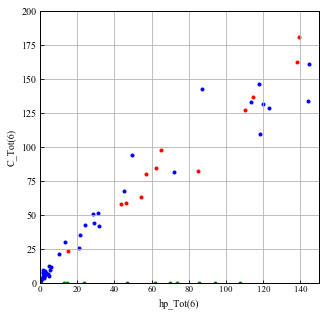

In [50]:
plt.figure(figsize=(5, 5))
for i in range(len(df_event_num)):
    x = df_event_num[i]["hp_Tot(6)"]
    y = df_event_num[i]["C_Tot(6)"]

    plt.scatter(x, y, marker='.', color=event_color_2018[i])
    plt.xlim(0, 150)
    plt.ylim(0, 200)
    plt.xlabel("hp_Tot(6)")
    plt.ylabel("C_Tot(6)")

In [51]:
# イベント３のデータが死んでいるので、イベント１、２，４，５を結合
df_13 = pd.concat([df_event_num[0], df_event_num[2]], sort=False)

Text(0, 0.5, 'C_Tot(6)')

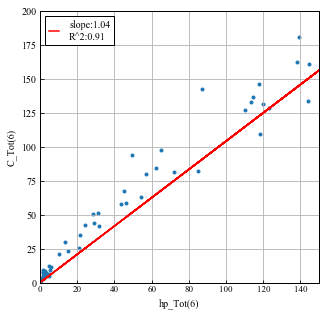

In [52]:
plt.figure(figsize=(5, 5))
slope_hp_C = linear_regression(df_13["hp_Tot(6)"], df_13["C_Tot(6)"])
x = df_13["hp_Tot(6)"]
y = df_13["C_Tot(6)"]
plt.scatter(x, y, marker='.')
plt.xlim(0, 150)
plt.ylim(0, 200)
plt.xlabel("hp_Tot(6)")
plt.ylabel("C_Tot(6)")

In [53]:
print("Y(C) = " + str(round(slope_hp_C, 3)) + "X(hp)")

Y(C) = 1.041X(hp)


Text(0, 0.5, 'C_Tot(6)')

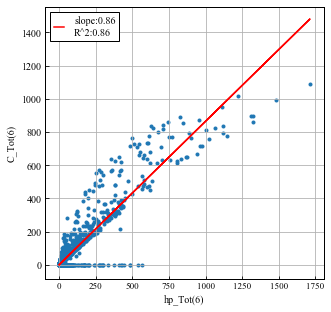

In [54]:
# 全ての"hp_Tot(6)"と"C_Tot(6)"データとの比較
plt.figure(figsize=(5, 5))
slope_hp_C_all = linear_regression(df_fin["hp_Tot(6)"], df_fin["C_Tot(6)"])
plt.scatter(df_fin["hp_Tot(6)"], df_fin["C_Tot(6)"], marker='.')
plt.xlabel("hp_Tot(6)")
plt.ylabel("C_Tot(6)")

In [55]:
print("Y = " + str(round(slope_hp_C_all, 3)) + "X")

Y = 0.864X


## 年間流砂量の算出

In [56]:
#指定スロットナンバーのデータ名を抽出
colnames_of_slot_sellected = [i for i in colnames_of_RRCCLCL if str(slot_num) in i]
print(colnames_of_slot_sellected)

['R_Tot(6)', 'RC_Tot(6)', 'C_Tot(6)', 'LC_Tot(6)', 'L_Tot(6)']


In [57]:
print("Y(Pulses(min-1)) = " + str(round(slope, 3)) +
      " X(Bedload Discharge(kg min-1))")

Y(Pulses(min-1)) = 45.272 X(Bedload Discharge(kg min-1))


In [58]:
print("Y = " + str(round(slope_hp_C, 3)) + "X")

Y = 1.041X


In [59]:
print(colnames_of_slot_sellected)

['R_Tot(6)', 'RC_Tot(6)', 'C_Tot(6)', 'LC_Tot(6)', 'L_Tot(6)']


In [60]:
for name in colnames_of_slot_sellected:
    df_all["sediment_discharge_calc"+name] = df_all[name] / slope_hp_C / slope
    df_all["sediment_discharge_cumsum_calc" +
           name] = df_all["sediment_discharge_calc"+name].cumsum()

Text(0, 0.5, 'Cumulative sediment_discharge[kg/m/year]')

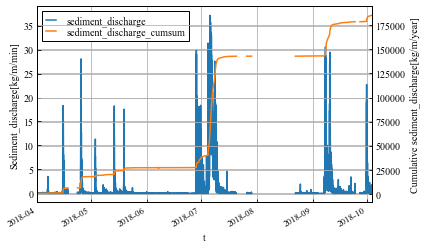

In [61]:
%matplotlib inline
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = df_all['sediment_discharge_calc'+name]['2018-4 0:00':
                                        '2018-11 0:00'].plot(label='sediment_discharge', color='C0')
ax2 = ax1.twinx()
ax2 = df_all['sediment_discharge_cumsum_calc'+name]['2018-4 0:00':
                                               '2018-11 0:00'].plot(label='sediment_discharge_cumsum', color='C1')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')
ax1.set_xlabel('t')
ax1.set_ylabel('Sediment_discharge[kg/m/min]')
ax1.grid(True)
ax2.set_ylabel('Cumulative sediment_discharge[kg/m/year]')

In [62]:
cumsum_of_all = df_all['sediment_discharge_cumsum_calc'+name][-1]
print('2018年4月～10月の累積流砂量は：' + str(cumsum_of_all) + ' kg')

2018年4月～10月の累積流砂量は：185349.8925757924 kg


R_Tot(6) 21.10547103471371
RC_Tot(6) 32.09791270581581
C_Tot(6) 81.36643134080272
LC_Tot(6) 210.86150612815743
L_Tot(6) 185.34989257579238
合計：530.781213785282t


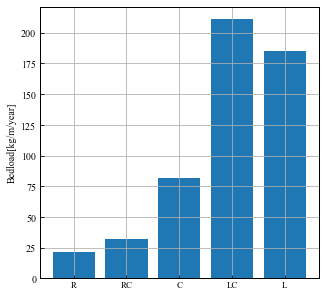

In [63]:
save_dir_seminers = './graphs_for_seminers/'
discharge_AprtoOct_t = []
for name in colnames_of_slot_sellected:
    discharge_AprtoOct_t.append(
        df_all["sediment_discharge_cumsum_calc"+name][-1]/1000)
    print(name, df_all["sediment_discharge_cumsum_calc"+name][-1]/1000)

print('合計：' + str(sum(discharge_AprtoOct_t)) + 't')

%matplotlib inline
plt.figure(figsize=(5,5))
x = np.array(['R','RC','C','LC','L'])
y = np.array(discharge_AprtoOct_t)
plt.ylabel('Bedload[kg/m/year]')
plt.bar(x, y)

plt.savefig(os.path.join(save_dir_seminers, "Bedload_year" +
                         y_name + process + str(len(df_event_num)) + 'events'))

## センターハイドロフォンとピットの流砂量との相関から、横断分布を計算し、動画として保存

<IPython.core.display.Javascript object>


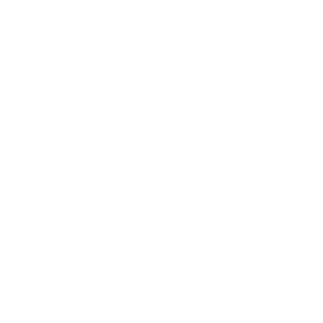

MovieWriter imagemagick unavailable. Trying to use pillow instead.


<IPython.core.display.Javascript object>


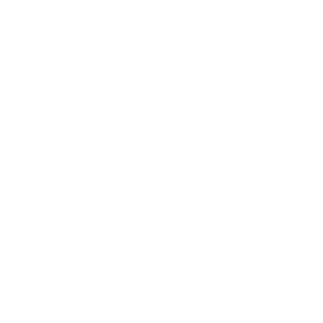

Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "C:\Users\user\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [64]:
save_dir_seminers = './graphs_for_seminers/' 
#イベント番号を入力（１～５まで）
event_num=2
#スロットナンバーを入力（１～10まで）
slot_num=6
#イベント番号とスロットナンバーを入力したらCrtlプラスEnterでグラフ表示

place_of_hydrophones = ['L_Tot({})'.format(slot_num),'LC_Tot({})'.format(slot_num),'C_Tot({})'.format(slot_num),'RC_Tot({})'.format(slot_num),'R_Tot({})'.format(slot_num)]
df = df_event_num[event_num-1][place_of_hydrophones] / slope_hp_C /slope
    
%matplotlib nbagg

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)

x = np.array(['R', 'RC', 'C', 'LC', 'L'])
max_ylim = max(df.max())
def update(i, fig_title, A):
    if i != 0:
        # 現在描写されているグラフを消去
        plt.cla()

    y = [df[place_of_hydrophones[4]][i], df[place_of_hydrophones[3]][i], df[place_of_hydrophones[2]][i],df[place_of_hydrophones[1]][i], df[place_of_hydrophones[0]][i]]
    plt.bar(x, y)
    plt.grid()
    
    plt.xlabel("x", fontsize = 15)
    plt.ylabel("Load_Avg_Difference", fontsize = 15)
    
    plt.ylim(0,max_ylim)

    plt.title(fig_title + ":" + str(df.index[i]))


ani = animation.FuncAnimation(fig, update, fargs = ('TIMESTAMP ', 2.0), \
    interval = 200, frames = len(df.index), repeat = False)

ani.save(os.path.join(save_dir_seminers, 'animation_event'+ str(event_num) + str(len(df_event_num)) + 'events' + '.gif'), writer = 'imagemagick')

<BarContainer object of 5 artists>

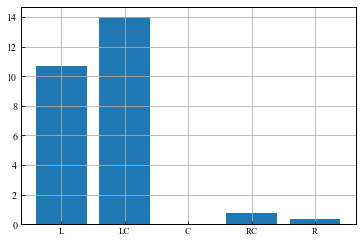

In [65]:
%matplotlib inline
i=4
x = np.array(['L', 'LC', 'C', 'RC', 'R'])
y =np.array([df[place_of_hydrophones[0]][i], df[place_of_hydrophones[1]][i], df[place_of_hydrophones[2]][i],df[place_of_hydrophones[3]][i], df[place_of_hydrophones[4]][i]])
plt.bar(x, y)

## 粒径ごとのデータに重さをかけて、ソルバー

In [66]:
data_type = 'hp_Tot'

# data_typeのデータのcolumn名を取り出す
names_of_data_type = []
names_of_data_type = [i for i in df_dia_all_2018.columns if data_type in i]

In [67]:
from scipy.optimize import minimize

In [68]:
# 目的関数
def func(W):
    Cost = 0
    W = W.reshape(1,10)
    print('W', W.shape)
    for i in range(len(df_event_num)):
#         if i == 2:
#             pass
#         elif i == 3:
#             pass
#         else:
            Y = df_event_num[i]['Load_Avg_difference'].values.reshape(len(df_event_num[i]['Load_Avg_difference']),1)
#             print('Y' , Y.shape)
            X = df_event_num[i][names_of_data_type]
#             print('X', X.shape)
            Z = np.dot(X, W.T)
#             print('Z', Z.shape)
            A0 = np.abs(Z-Y)
#             print('A0' , A0.shape)
            A1 = np.power(A0,2)
#             print('A1' , A1.shape)
            cost = np.sum(A1 ,axis=0, keepdims=True)
#             print('cost' , cost.shape)
            Cost = Cost + cost[0][0]
    print('Cost' , Cost)
    return Cost

cons = ({'type': 'ineq', 'fun': lambda W: W[1]-W[0]},
        {'type': 'ineq', 'fun': lambda W: W[2]-W[1]},
        {'type': 'ineq', 'fun': lambda W: W[3]-W[2]},
        {'type': 'ineq', 'fun': lambda W: W[4]-W[3]},
        {'type': 'ineq', 'fun': lambda W: W[5]-W[4]},
        {'type': 'ineq', 'fun': lambda W: W[6]-W[5]},
        {'type': 'ineq', 'fun': lambda W: W[7]-W[6]},
        {'type': 'ineq', 'fun': lambda W: W[8]-W[7]},
        {'type': 'ineq', 'fun': lambda W: W[9]-W[8]},
        {'type': 'ineq', 'fun': lambda W: W[0]}
       )

times_of_try = 100
minmum_cost = 100
temp = []
W_ans = []
results = []
for i in range(times_of_try):
    W0 = np.random.rand(1,10)# 初期値は適当
    result = minimize(func, x0=W0, constraints=cons, method="SLSQP")
    if result.fun < minmum_cost:
        minmum_cost = result.fun
        W_ans.append([i, result.x])
        temp.append([i, minmum_cost])
        results.append([i, result])
    

W (1, 10)
Cost 483730761.8456821
W (1, 10)
Cost 483730761.8456821
W (1, 10)
Cost 483730767.8194881
W (1, 10)
Cost 483730766.87476283
W (1, 10)
Cost 483730765.67851675
W (1, 10)
Cost 483730764.4226717
W (1, 10)
Cost 483730763.48370904
W (1, 10)
Cost 483730762.66795754
W (1, 10)
Cost 483730762.26783144
W (1, 10)
Cost 483730762.0625802
W (1, 10)
Cost 483730761.95732486
W (1, 10)
Cost 483730761.87508285
W (1, 10)
Cost 7.67368219784598e+25
W (1, 10)
Cost 7.67368185166948e+23
W (1, 10)
Cost 7.673678389904893e+21
W (1, 10)
Cost 7.673643772302123e+19
W (1, 10)
Cost 7.673297600584468e+17
W (1, 10)
Cost 7669836314412024.0
W (1, 10)
Cost 76352665530984.52
W (1, 10)
Cost 729387898105.0773
W (1, 10)
Cost 4311007369.378475
W (1, 10)
Cost 1735912.0710133482
W (1, 10)
Cost 1735912.0710133482
W (1, 10)
Cost 1735912.0679482592
W (1, 10)
Cost 1735912.081109904
W (1, 10)
Cost 1735912.0920806502
W (1, 10)
Cost 1735912.0979505405
W (1, 10)
Cost 1735912.0994858989
W (1, 10)
Cost 1735912.094368778
W (1, 10)
C

Cost 1187746.6280419086
W (1, 10)
Cost 1.283867864947239e+16
W (1, 10)
Cost 128382820719788.94
W (1, 10)
Cost 1283432687986.6362
W (1, 10)
Cost 12795833240.985434
W (1, 10)
Cost 125167250.76615338
W (1, 10)
Cost 2030846.5876837499
W (1, 10)
Cost 1152025.677427796
W (1, 10)
Cost 1168575.1647999662
W (1, 10)
Cost 1177780.1047536898
W (1, 10)
Cost 1182429.5559284315
W (1, 10)
Cost 1184860.8466397545
W (1, 10)
Cost 1184860.8466397545
W (1, 10)
Cost 1184860.8597968821
W (1, 10)
Cost 1184860.8681184584
W (1, 10)
Cost 1184860.8739401305
W (1, 10)
Cost 1184860.8754168607
W (1, 10)
Cost 1184860.8742104967
W (1, 10)
Cost 1184860.8679551182
W (1, 10)
Cost 1184860.8625911835
W (1, 10)
Cost 1184860.85708049
W (1, 10)
Cost 1184860.8525115815
W (1, 10)
Cost 1184860.8479686212
W (1, 10)
Cost 3827884546837829.0
W (1, 10)
Cost 38276708753461.64
W (1, 10)
Cost 382554471753.9654
W (1, 10)
Cost 3805338850.488904
W (1, 10)
Cost 37088512.81416996
W (1, 10)
Cost 1330108.573425814
W (1, 10)
Cost 1152594.955899

Cost 53.70996728360798
W (1, 10)
Cost 53.709967273656915
W (1, 10)
Cost 53.709797169774035
W (1, 10)
Cost 53.709797169774035
W (1, 10)
Cost 53.70979416518185
W (1, 10)
Cost 53.70979573673244
W (1, 10)
Cost 53.70979904856533
W (1, 10)
Cost 53.7097994395869
W (1, 10)
Cost 53.70979740449652
W (1, 10)
Cost 53.70979715994224
W (1, 10)
Cost 53.70979717776892
W (1, 10)
Cost 53.70979711740246
W (1, 10)
Cost 53.70979720330275
W (1, 10)
Cost 53.70979718833148
W (1, 10)
Cost 48657321.50008395
W (1, 10)
Cost 48657321.50008395
W (1, 10)
Cost 48657323.3643868
W (1, 10)
Cost 48657323.07773664
W (1, 10)
Cost 48657322.71035025
W (1, 10)
Cost 48657322.32041955
W (1, 10)
Cost 48657322.02663639
W (1, 10)
Cost 48657321.76797177
W (1, 10)
Cost 48657321.63983763
W (1, 10)
Cost 48657321.572882876
W (1, 10)
Cost 48657321.537793785
W (1, 10)
Cost 48657321.509895384
W (1, 10)
Cost 325032278.6272354
W (1, 10)
Cost 325032278.6272354
W (1, 10)
Cost 325032283.52811563
W (1, 10)
Cost 325032282.7517988
W (1, 10)
Cost 

Cost 674818.6343051273
W (1, 10)
Cost 674818.6302920032
W (1, 10)
Cost 674818.6219411474
W (1, 10)
Cost 674818.6135838343
W (1, 10)
Cost 674818.602402091
W (1, 10)
Cost 674818.5953219617
W (1, 10)
Cost 674818.5899193325
W (1, 10)
Cost 674818.5860367462
W (1, 10)
Cost 674818.5823483226
W (1, 10)
Cost 7.309531873558719e+17
W (1, 10)
Cost 7309491236274926.0
W (1, 10)
Cost 73090849235633.31
W (1, 10)
Cost 730502780908.0924
W (1, 10)
Cost 7265057927.612732
W (1, 10)
Cost 69254854.48518774
W (1, 10)
Cost 954239.4216375807
W (1, 10)
Cost 616815.0804472805
W (1, 10)
Cost 648865.921906846
W (1, 10)
Cost 663537.0999657223
W (1, 10)
Cost 669866.1301083557
W (1, 10)
Cost 669866.1301083557
W (1, 10)
Cost 669866.1803349286
W (1, 10)
Cost 669866.1809910531
W (1, 10)
Cost 669866.177501194
W (1, 10)
Cost 669866.1696988747
W (1, 10)
Cost 669866.1617513113
W (1, 10)
Cost 669866.1509240726
W (1, 10)
Cost 669866.1440170964
W (1, 10)
Cost 669866.1387023131
W (1, 10)
Cost 669866.1348641483
W (1, 10)
Cost 669

Cost 1608686042.1163235
W (1, 10)
Cost 15848534.690008365
W (1, 10)
Cost 1346179.6334372777
W (1, 10)
Cost 1319055.6275071604
W (1, 10)
Cost 1319055.6275071604
W (1, 10)
Cost 1319055.608334256
W (1, 10)
Cost 1319055.6247096881
W (1, 10)
Cost 1319055.6385176964
W (1, 10)
Cost 1319055.646458271
W (1, 10)
Cost 1319055.6490675607
W (1, 10)
Cost 1319055.645477042
W (1, 10)
Cost 1319055.6413780747
W (1, 10)
Cost 1319055.6367204294
W (1, 10)
Cost 1319055.632733583
W (1, 10)
Cost 1319055.6286635753
W (1, 10)
Cost 32239484627578.805
W (1, 10)
Cost 321237842595.9908
W (1, 10)
Cost 3097853336.544285
W (1, 10)
Cost 20701302.98798933
W (1, 10)
Cost 221502.73892328577
W (1, 10)
Cost 221502.73892328577
W (1, 10)
Cost 221502.74631490035
W (1, 10)
Cost 221502.7494845501
W (1, 10)
Cost 221502.75148408863
W (1, 10)
Cost 221502.75171939938
W (1, 10)
Cost 221502.75101282794
W (1, 10)
Cost 221502.74828621146
W (1, 10)
Cost 221502.74597396763
W (1, 10)
Cost 221502.7435552367
W (1, 10)
Cost 221502.74153149113

Cost 596425.4276850118
W (1, 10)
Cost 710847.7956932
W (1, 10)
Cost 742901.0530884479
W (1, 10)
Cost 742901.0530884479
W (1, 10)
Cost 742901.0777270044
W (1, 10)
Cost 742901.0802418364
W (1, 10)
Cost 742901.081071016
W (1, 10)
Cost 742901.0795460183
W (1, 10)
Cost 742901.0772376789
W (1, 10)
Cost 742901.071485244
W (1, 10)
Cost 742901.066847956
W (1, 10)
Cost 742901.062099404
W (1, 10)
Cost 742901.0581475943
W (1, 10)
Cost 742901.0542484706
W (1, 10)
Cost 289241094.5871492
W (1, 10)
Cost 289241094.5871492
W (1, 10)
Cost 289241099.2076947
W (1, 10)
Cost 289241098.4775928
W (1, 10)
Cost 289241097.5523709
W (1, 10)
Cost 289241096.58033913
W (1, 10)
Cost 289241095.8531379
W (1, 10)
Cost 289241095.22150815
W (1, 10)
Cost 289241094.9119438
W (1, 10)
Cost 289241094.7536307
W (1, 10)
Cost 289241094.67276925
W (1, 10)
Cost 289241094.6097212
W (1, 10)
Cost 4.525206401368664e+25
W (1, 10)
Cost 4.525206195748394e+23
W (1, 10)
Cost 4.52520413954595e+21
W (1, 10)
Cost 4.52518357754728e+19
W (1, 10)


Cost 312414.61729215423
W (1, 10)
Cost 312414.61729215423
W (1, 10)
Cost 312414.63735746185
W (1, 10)
Cost 312414.6332842717
W (1, 10)
Cost 312414.62994778727
W (1, 10)
Cost 312414.62813487696
W (1, 10)
Cost 312414.6278577032
W (1, 10)
Cost 312414.62671542837
W (1, 10)
Cost 312414.62523681024
W (1, 10)
Cost 312414.62277680653
W (1, 10)
Cost 312414.62039002276
W (1, 10)
Cost 312414.6180208009
W (1, 10)
Cost 250232984.9961181
W (1, 10)
Cost 1427259.9557497369
W (1, 10)
Cost 185127.0341436623
W (1, 10)
Cost 185127.0341436623
W (1, 10)
Cost 185127.0425214946
W (1, 10)
Cost 185127.03926998706
W (1, 10)
Cost 185127.03737188017
W (1, 10)
Cost 185127.03740407457
W (1, 10)
Cost 185127.0386176426
W (1, 10)
Cost 185127.0393564097
W (1, 10)
Cost 185127.0391129724
W (1, 10)
Cost 185127.0377297717
W (1, 10)
Cost 185127.03618412008
W (1, 10)
Cost 185127.0346217767
W (1, 10)
Cost 6250.464966488793
W (1, 10)
Cost 6250.464966488793
W (1, 10)
Cost 6250.486022357298
W (1, 10)
Cost 6250.48281069373
W (1, 1

Cost 54.1608678135349
W (1, 10)
Cost 54.160867940365776
W (1, 10)
Cost 54.16086677379202
W (1, 10)
Cost 54.16086533812282
W (1, 10)
Cost 54.16086346231435
W (1, 10)
Cost 54.16086198669049
W (1, 10)
Cost 54.160860372682464
W (1, 10)
Cost 54.27794455564311
W (1, 10)
Cost 53.86336965649284
W (1, 10)
Cost 53.86336965649284
W (1, 10)
Cost 53.863410216095986
W (1, 10)
Cost 53.8634042979169
W (1, 10)
Cost 53.86339874618383
W (1, 10)
Cost 53.863390406412364
W (1, 10)
Cost 53.86338234714944
W (1, 10)
Cost 53.86337679975239
W (1, 10)
Cost 53.86337411609699
W (1, 10)
Cost 53.863372297627926
W (1, 10)
Cost 53.86337121058763
W (1, 10)
Cost 53.86337013293182
W (1, 10)
Cost 53.79720962168713
W (1, 10)
Cost 53.79720962168713
W (1, 10)
Cost 53.7972454322271
W (1, 10)
Cost 53.79724156972183
W (1, 10)
Cost 53.797237459751116
W (1, 10)
Cost 53.79722964416297
W (1, 10)
Cost 53.7972211255896
W (1, 10)
Cost 53.7972152067202
W (1, 10)
Cost 53.79721238277039
W (1, 10)
Cost 53.79721080558563
W (1, 10)
Cost 53.7

Cost 53.829505764844136
W (1, 10)
Cost 54.1690537506877
W (1, 10)
Cost 53.77498839633921
W (1, 10)
Cost 53.77498839633921
W (1, 10)
Cost 53.77495551203897
W (1, 10)
Cost 53.77496048303473
W (1, 10)
Cost 53.774969219592066
W (1, 10)
Cost 53.77497647643191
W (1, 10)
Cost 53.77498022986694
W (1, 10)
Cost 53.774985243719215
W (1, 10)
Cost 53.774987685391025
W (1, 10)
Cost 53.7749883232179
W (1, 10)
Cost 53.774988456347344
W (1, 10)
Cost 53.7749883900442
W (1, 10)
Cost 53.724166663380394
W (1, 10)
Cost 53.724166663380394
W (1, 10)
Cost 53.72417109427382
W (1, 10)
Cost 53.72417229508761
W (1, 10)
Cost 53.72417444544115
W (1, 10)
Cost 53.72417294718109
W (1, 10)
Cost 53.72416908339132
W (1, 10)
Cost 53.724167164453426
W (1, 10)
Cost 53.72416643550603
W (1, 10)
Cost 53.72416624611367
W (1, 10)
Cost 53.72416645226602
W (1, 10)
Cost 53.72416661835919
W (1, 10)
Cost 53.71036648403444
W (1, 10)
Cost 53.71036648403444
W (1, 10)
Cost 53.71036676518025
W (1, 10)
Cost 53.71036764290844
W (1, 10)
Cost 

Cost 57.39685127640969
W (1, 10)
Cost 57.396878170620155
W (1, 10)
Cost 57.39689717775845
W (1, 10)
Cost 57.39690285745423
W (1, 10)
Cost 57.3968997095446
W (1, 10)
Cost 57.39689441616268
W (1, 10)
Cost 57.39688840047094
W (1, 10)
Cost 62.780670664604834
W (1, 10)
Cost 55.435455998295005
W (1, 10)
Cost 55.435455998295005
W (1, 10)
Cost 55.43550268794613
W (1, 10)
Cost 55.4355108798515
W (1, 10)
Cost 55.43551521899786
W (1, 10)
Cost 55.43550951016427
W (1, 10)
Cost 55.435499018519245
W (1, 10)
Cost 55.435484917834614
W (1, 10)
Cost 55.435475579469
W (1, 10)
Cost 55.43546800225404
W (1, 10)
Cost 55.43546264187951
W (1, 10)
Cost 55.43545747337376
W (1, 10)
Cost 67.04615835260566
W (1, 10)
Cost 54.17264216687983
W (1, 10)
Cost 54.17264216687983
W (1, 10)
Cost 54.17268003106756
W (1, 10)
Cost 54.17268066743938
W (1, 10)
Cost 54.17267948706156
W (1, 10)
Cost 54.17267170176042
W (1, 10)
Cost 54.17266186507456
W (1, 10)
Cost 54.172652696317925
W (1, 10)
Cost 54.172647944947954
W (1, 10)
Cost 5

Cost 2101.980853546123
W (1, 10)
Cost 2101.980626019534
W (1, 10)
Cost 2081.6955660927097
W (1, 10)
Cost 2081.6955660927097
W (1, 10)
Cost 2081.701743209279
W (1, 10)
Cost 2081.7008754520175
W (1, 10)
Cost 2081.699783292074
W (1, 10)
Cost 2081.6986304025395
W (1, 10)
Cost 2081.697781943994
W (1, 10)
Cost 2081.696936744491
W (1, 10)
Cost 2081.696460047943
W (1, 10)
Cost 2081.696115524574
W (1, 10)
Cost 2081.695871451068
W (1, 10)
Cost 2081.695645054887
W (1, 10)
Cost 2006.1890331057357
W (1, 10)
Cost 2048.076608619747
W (1, 10)
Cost 2048.076608619747
W (1, 10)
Cost 2048.082710336003
W (1, 10)
Cost 2048.0818536570646
W (1, 10)
Cost 2048.080775426754
W (1, 10)
Cost 2048.0796372449636
W (1, 10)
Cost 2048.0787997832354
W (1, 10)
Cost 2048.077965049557
W (1, 10)
Cost 2048.077493956776
W (1, 10)
Cost 2048.07715300674
W (1, 10)
Cost 2048.076911230456
W (1, 10)
Cost 2048.076686878033
W (1, 10)
Cost 1679.4286171838128
W (1, 10)
Cost 1679.4286171838128
W (1, 10)
Cost 1679.4338842548127
W (1, 10)


Cost 8098.403891952738
W (1, 10)
Cost 8098.403891952738
W (1, 10)
Cost 8098.425059039101
W (1, 10)
Cost 8098.422194781649
W (1, 10)
Cost 8098.418265201558
W (1, 10)
Cost 8098.413814159912
W (1, 10)
Cost 8098.410287353175
W (1, 10)
Cost 8098.407061101896
W (1, 10)
Cost 8098.405459667454
W (1, 10)
Cost 8098.404671523702
W (1, 10)
Cost 8098.404291858397
W (1, 10)
Cost 8098.403995428867
W (1, 10)
Cost 474.7000735077406
W (1, 10)
Cost 474.7000735077406
W (1, 10)
Cost 474.69546575109484
W (1, 10)
Cost 474.6961447191867
W (1, 10)
Cost 474.6970168355695
W (1, 10)
Cost 474.6979406263992
W (1, 10)
Cost 474.6986324760759
W (1, 10)
Cost 474.69927203123825
W (1, 10)
Cost 474.699606586436
W (1, 10)
Cost 474.69980843583994
W (1, 10)
Cost 474.69993177320646
W (1, 10)
Cost 474.70003811078607
W (1, 10)
Cost 595.9605316464997
W (1, 10)
Cost 121.66929303951437
W (1, 10)
Cost 121.66929303951437
W (1, 10)
Cost 121.66783264509006
W (1, 10)
Cost 121.66806507342216
W (1, 10)
Cost 121.66836996778348
W (1, 10)
C

Cost 722.4966347972311
W (1, 10)
Cost 722.4970579757137
W (1, 10)
Cost 722.4973125776637
W (1, 10)
Cost 722.4974673443614
W (1, 10)
Cost 722.4976009778707
W (1, 10)
Cost 228.1505468239227
W (1, 10)
Cost 228.1505468239227
W (1, 10)
Cost 228.1499324294452
W (1, 10)
Cost 228.15006528673507
W (1, 10)
Cost 228.15023970540523
W (1, 10)
Cost 228.1504215448923
W (1, 10)
Cost 228.1505621093074
W (1, 10)
Cost 228.1506476508899
W (1, 10)
Cost 228.15066747969897
W (1, 10)
Cost 228.15064137740626
W (1, 10)
Cost 228.15060361403886
W (1, 10)
Cost 228.1505610294367
W (1, 10)
Cost 242.3365495805621
W (1, 10)
Cost 98.1827803429515
W (1, 10)
Cost 98.1827803429515
W (1, 10)
Cost 98.18410846562243
W (1, 10)
Cost 98.1839217521606
W (1, 10)
Cost 98.18367902488728
W (1, 10)
Cost 98.18341267672562
W (1, 10)
Cost 98.18320875755049
W (1, 10)
Cost 98.18301903915
W (1, 10)
Cost 98.18292004676299
W (1, 10)
Cost 98.18286052971095
W (1, 10)
Cost 98.18282414521288
W (1, 10)
Cost 98.1827919853146
W (1, 10)
Cost 55.3935

W (1, 10)
Cost 54.27637683979471
W (1, 10)
Cost 54.276352888750424
W (1, 10)
Cost 54.2763327465194
W (1, 10)
Cost 54.27632269472406
W (1, 10)
Cost 54.27631695435494
W (1, 10)
Cost 54.276313716002235
W (1, 10)
Cost 54.276310802939065
W (1, 10)
Cost 53.797533381613626
W (1, 10)
Cost 53.797533381613626
W (1, 10)
Cost 53.797522163007
W (1, 10)
Cost 53.797527036572696
W (1, 10)
Cost 53.797533275285
W (1, 10)
Cost 53.79753561463234
W (1, 10)
Cost 53.79753429936605
W (1, 10)
Cost 53.797534102108095
W (1, 10)
Cost 53.797533897709755
W (1, 10)
Cost 53.7975335205178
W (1, 10)
Cost 53.79753343447594
W (1, 10)
Cost 53.7975333372121
W (1, 10)
Cost 65.46390700474609
W (1, 10)
Cost 53.81337393814465
W (1, 10)
Cost 53.77299649247023
W (1, 10)
Cost 53.77299649247023
W (1, 10)
Cost 53.77296664244492
W (1, 10)
Cost 53.77297379065759
W (1, 10)
Cost 53.77298325849346
W (1, 10)
Cost 53.772989271912664
W (1, 10)
Cost 53.772990919527146
W (1, 10)
Cost 53.772993557815724
W (1, 10)
Cost 53.772994899228884
W (1,

Cost 1.771289841660003e+19
W (1, 10)
Cost 1.7712065276300822e+17
W (1, 10)
Cost 1770373496955263.0
W (1, 10)
Cost 17620541526457.633
W (1, 10)
Cost 167995695342.03357
W (1, 10)
Cost 968609348.1237667
W (1, 10)
Cost 2142049.677007778
W (1, 10)
Cost 2142049.677007778
W (1, 10)
Cost 2142049.72095138
W (1, 10)
Cost 2142049.726639702
W (1, 10)
Cost 2142049.728467446
W (1, 10)
Cost 2142049.725078131
W (1, 10)
Cost 2142049.7199657476
W (1, 10)
Cost 2142049.7088329094
W (1, 10)
Cost 2142049.7003090847
W (1, 10)
Cost 2142049.69211125
W (1, 10)
Cost 2142049.685470799
W (1, 10)
Cost 2142049.678947693
W (1, 10)
Cost 135462205327733.52
W (1, 10)
Cost 1351765569977.4612
W (1, 10)
Cost 13233915936.049423
W (1, 10)
Cost 105873749.25018916
W (1, 10)
Cost 320762.743685313
W (1, 10)
Cost 1159927.6092626057
W (1, 10)
Cost 1159927.6092626057
W (1, 10)
Cost 1159927.661267848
W (1, 10)
Cost 1159927.6603810485
W (1, 10)
Cost 1159927.6567168087
W (1, 10)
Cost 1159927.6502757946
W (1, 10)
Cost 1159927.644292227

Cost 1973265.3974713804
W (1, 10)
Cost 1973265.390283377
W (1, 10)
Cost 1973265.3843836703
W (1, 10)
Cost 1973265.3785308653
W (1, 10)
Cost 2372779653236811.0
W (1, 10)
Cost 23725581178371.28
W (1, 10)
Cost 237036034563.48093
W (1, 10)
Cost 2350140803.062358
W (1, 10)
Cost 23237633.22412029
W (1, 10)
Cost 1964178.3023327019
W (1, 10)
Cost 1919848.6637939794
W (1, 10)
Cost 1939674.980086765
W (1, 10)
Cost 1939674.980086765
W (1, 10)
Cost 1939674.9786138113
W (1, 10)
Cost 1939674.9928084617
W (1, 10)
Cost 1939675.0041193087
W (1, 10)
Cost 1939675.0096857697
W (1, 10)
Cost 1939675.010758021
W (1, 10)
Cost 1939675.0049903342
W (1, 10)
Cost 1939674.999232087
W (1, 10)
Cost 1939674.9927797788
W (1, 10)
Cost 1939674.9872565654
W (1, 10)
Cost 1939674.981697968
W (1, 10)
Cost 682201608.2940006
W (1, 10)
Cost 682201608.2940006
W (1, 10)
Cost 682201615.3967566
W (1, 10)
Cost 682201614.2724546
W (1, 10)
Cost 682201612.8483899
W (1, 10)
Cost 682201611.3531365
W (1, 10)
Cost 682201610.2349726
W (1, 

Cost 391620230.1474988
W (1, 10)
Cost 391620229.9619966
W (1, 10)
Cost 391620229.86619246
W (1, 10)
Cost 391620229.79104006
W (1, 10)
Cost 6.096291659184677e+25
W (1, 10)
Cost 6.096291381771627e+23
W (1, 10)
Cost 6.096288607641447e+21
W (1, 10)
Cost 6.096260866374547e+19
W (1, 10)
Cost 6.095983457194879e+17
W (1, 10)
Cost 6093209714331820.0
W (1, 10)
Cost 60655071790637.0
W (1, 10)
Cost 579197116262.968
W (1, 10)
Cost 3405544623.009429
W (1, 10)
Cost 2016563.6312491333
W (1, 10)
Cost 2016563.6312491333
W (1, 10)
Cost 2016563.6487464237
W (1, 10)
Cost 2016563.6562165793
W (1, 10)
Cost 2016563.6620612785
W (1, 10)
Cost 2016563.6645174366
W (1, 10)
Cost 2016563.6645994615
W (1, 10)
Cost 2016563.6585343438
W (1, 10)
Cost 2016563.6525425836
W (1, 10)
Cost 2016563.6454650965
W (1, 10)
Cost 2016563.6392710174
W (1, 10)
Cost 2016563.6330732456
W (1, 10)
Cost 164237601213.11093
W (1, 10)
Cost 1549978747.4343283
W (1, 10)
Cost 8056819.200108178
W (1, 10)
Cost 770539.337360879
W (1, 10)
Cost 1523

Cost 677431.7181038848
W (1, 10)
Cost 677431.7127441304
W (1, 10)
Cost 677431.7083835527
W (1, 10)
Cost 677431.7038433948
W (1, 10)
Cost 677431.7000367845
W (1, 10)
Cost 677431.6962825566
W (1, 10)
Cost 248813886.28791714
W (1, 10)
Cost 248813886.28791714
W (1, 10)
Cost 248813890.58211917
W (1, 10)
Cost 248813889.89914978
W (1, 10)
Cost 248813889.0363779
W (1, 10)
Cost 248813888.13261333
W (1, 10)
Cost 248813887.45797288
W (1, 10)
Cost 248813886.87358618
W (1, 10)
Cost 248813886.5875483
W (1, 10)
Cost 248813886.441391
W (1, 10)
Cost 248813886.36679566
W (1, 10)
Cost 248813886.30874407
W (1, 10)
Cost 144631987.97243962
W (1, 10)
Cost 144631987.97243962
W (1, 10)
Cost 144631991.17581525
W (1, 10)
Cost 144631990.68433595
W (1, 10)
Cost 144631990.05418366
W (1, 10)
Cost 144631989.38517785
W (1, 10)
Cost 144631988.88118654
W (1, 10)
Cost 144631988.43665358
W (1, 10)
Cost 144631988.21596527
W (1, 10)
Cost 144631988.0998966
W (1, 10)
Cost 144631988.0385853
W (1, 10)
Cost 144631987.98960894
W 

Cost 53.70982831133988
W (1, 10)
Cost 53.70982829265381
W (1, 10)
Cost 53.70981696487664
W (1, 10)
Cost 53.70981696487664
W (1, 10)
Cost 53.70981425169222
W (1, 10)
Cost 53.709815805854404
W (1, 10)
Cost 53.70981907079825
W (1, 10)
Cost 53.70981938852249
W (1, 10)
Cost 53.709817283655156
W (1, 10)
Cost 53.7098169756271
W (1, 10)
Cost 53.70981696513606
W (1, 10)
Cost 53.7098168995899
W (1, 10)
Cost 53.70981698967627
W (1, 10)
Cost 53.709816981178015
W (1, 10)
Cost 53.709797295556115
W (1, 10)
Cost 53.709797295556115
W (1, 10)
Cost 53.70979424063692
W (1, 10)
Cost 53.70979582079951
W (1, 10)
Cost 53.70979914331568
W (1, 10)
Cost 53.70979954533034
W (1, 10)
Cost 53.70979751835698
W (1, 10)
Cost 53.70979728045644
W (1, 10)
Cost 53.70979730134293
W (1, 10)
Cost 53.70979724227156
W (1, 10)
Cost 53.709797328661125
W (1, 10)
Cost 53.70979731398202
W (1, 10)
Cost 346540350.96031123
W (1, 10)
Cost 346540350.96031123
W (1, 10)
Cost 346540355.99710613
W (1, 10)
Cost 346540355.20803356
W (1, 10)
Co

Cost 367622.1585474056
W (1, 10)
Cost 367622.1579599689
W (1, 10)
Cost 367622.157256461
W (1, 10)
Cost 367622.1543934926
W (1, 10)
Cost 367622.1517380641
W (1, 10)
Cost 367622.14858027257
W (1, 10)
Cost 367622.1457952305
W (1, 10)
Cost 367622.1430284062
W (1, 10)
Cost 10269764.963453118
W (1, 10)
Cost 201051.48697598188
W (1, 10)
Cost 264049.413536289
W (1, 10)
Cost 304542.1083604448
W (1, 10)
Cost 304542.1083604448
W (1, 10)
Cost 304542.1228143445
W (1, 10)
Cost 304542.1243187243
W (1, 10)
Cost 304542.1248621099
W (1, 10)
Cost 304542.12414025585
W (1, 10)
Cost 304542.12304516806
W (1, 10)
Cost 304542.1198370994
W (1, 10)
Cost 304542.11711077834
W (1, 10)
Cost 304542.1141478531
W (1, 10)
Cost 304542.1116170725
W (1, 10)
Cost 304542.10911057907
W (1, 10)
Cost 22962.70867502697
W (1, 10)
Cost 22962.70867502697
W (1, 10)
Cost 22962.705981150488
W (1, 10)
Cost 22962.70856502345
W (1, 10)
Cost 22962.710483745686
W (1, 10)
Cost 22962.71132082156
W (1, 10)
Cost 22962.71137956951
W (1, 10)
Cos

Cost 726.8482878687328
W (1, 10)
Cost 726.8487319978565
W (1, 10)
Cost 726.8489905162712
W (1, 10)
Cost 726.8491429641304
W (1, 10)
Cost 726.8492720241036
W (1, 10)
Cost 800.6903904207757
W (1, 10)
Cost 800.6903904207757
W (1, 10)
Cost 800.697666938349
W (1, 10)
Cost 800.6965259352161
W (1, 10)
Cost 800.6950610487545
W (1, 10)
Cost 800.6935006543247
W (1, 10)
Cost 800.6923192835019
W (1, 10)
Cost 800.6913067898544
W (1, 10)
Cost 800.6908219096481
W (1, 10)
Cost 800.6905943551153
W (1, 10)
Cost 800.690491879958
W (1, 10)
Cost 800.6904182146807
W (1, 10)
Cost 258.30977958891367
W (1, 10)
Cost 258.30977958891367
W (1, 10)
Cost 258.30957023613934
W (1, 10)
Cost 258.30963314709766
W (1, 10)
Cost 258.30972257040406
W (1, 10)
Cost 258.30981762551016
W (1, 10)
Cost 258.30989624630035
W (1, 10)
Cost 258.3099293980454
W (1, 10)
Cost 258.3099247709074
W (1, 10)
Cost 258.3098870678875
W (1, 10)
Cost 258.3098436395559
W (1, 10)
Cost 258.30979668937357
W (1, 10)
Cost 149.05053649767152
W (1, 10)
Cos

Cost 206462.32926738058
W (1, 10)
Cost 208832.89479444863
W (1, 10)
Cost 209819.2090061897
W (1, 10)
Cost 210190.8412125461
W (1, 10)
Cost 210330.8040626122
W (1, 10)
Cost 210330.8040626122
W (1, 10)
Cost 210330.81962600347
W (1, 10)
Cost 210330.81612092673
W (1, 10)
Cost 210330.81334478155
W (1, 10)
Cost 210330.8120003496
W (1, 10)
Cost 210330.81199408465
W (1, 10)
Cost 210330.8113681385
W (1, 10)
Cost 210330.81033960654
W (1, 10)
Cost 210330.80843337235
W (1, 10)
Cost 210330.80653707805
W (1, 10)
Cost 210330.8046477712
W (1, 10)
Cost 145240326.42683828
W (1, 10)
Cost 145240326.42683828
W (1, 10)
Cost 145240329.70273384
W (1, 10)
Cost 145240329.18224227
W (1, 10)
Cost 145240328.52496833
W (1, 10)
Cost 145240327.83666185
W (1, 10)
Cost 145240327.32300192
W (1, 10)
Cost 145240326.8773111
W (1, 10)
Cost 145240326.65868875
W (1, 10)
Cost 145240326.54623038
W (1, 10)
Cost 145240326.4883357
W (1, 10)
Cost 145240326.44303212
W (1, 10)
Cost 2.1536555601338353e+25
W (1, 10)
Cost 2.153655459647

Cost 4.262281767721848e+23
W (1, 10)
Cost 4.262279829424795e+21
W (1, 10)
Cost 4.262260446478619e+19
W (1, 10)
Cost 4.262066619453882e+17
W (1, 10)
Cost 4260128592908751.0
W (1, 10)
Cost 42407726976814.664
W (1, 10)
Cost 404965076781.1688
W (1, 10)
Cost 2382133709.421034
W (1, 10)
Cost 1480507.185155566
W (1, 10)
Cost 1480507.185155566
W (1, 10)
Cost 1480507.2010316772
W (1, 10)
Cost 1480507.2115830532
W (1, 10)
Cost 1480507.2184509872
W (1, 10)
Cost 1480507.2194829006
W (1, 10)
Cost 1480507.2171355002
W (1, 10)
Cost 1480507.2090680522
W (1, 10)
Cost 1480507.2026082692
W (1, 10)
Cost 1480507.1964502223
W (1, 10)
Cost 1480507.1914993038
W (1, 10)
Cost 1480507.1865904927
W (1, 10)
Cost 245448700248.7605
W (1, 10)
Cost 2349990583.9430695
W (1, 10)
Cost 14369395.886950804
W (1, 10)
Cost 253467.404465302
W (1, 10)
Cost 253467.404465302
W (1, 10)
Cost 253467.43480498786
W (1, 10)
Cost 253467.43336393955
W (1, 10)
Cost 253467.43031377532
W (1, 10)
Cost 253467.42596667414
W (1, 10)
Cost 253467

Cost 1070064.3494708026
W (1, 10)
Cost 1070064.3449269668
W (1, 10)
Cost 5103611454961.16
W (1, 10)
Cost 50642263075.18184
W (1, 10)
Cost 467990910.6389698
W (1, 10)
Cost 1790164.4252324007
W (1, 10)
Cost 132402.21906893837
W (1, 10)
Cost 132402.21906893837
W (1, 10)
Cost 132402.2644331879
W (1, 10)
Cost 132402.25557535482
W (1, 10)
Cost 132402.2459173208
W (1, 10)
Cost 132402.23741452923
W (1, 10)
Cost 132402.2321170359
W (1, 10)
Cost 132402.22763310676
W (1, 10)
Cost 132402.22508231094
W (1, 10)
Cost 132402.22288965006
W (1, 10)
Cost 132402.2211708549
W (1, 10)
Cost 132402.21958804526
W (1, 10)
Cost 35501602.604860276
W (1, 10)
Cost 138946.51362066052
W (1, 10)
Cost 97752.89108383648
W (1, 10)
Cost 126898.88071521097
W (1, 10)
Cost 131582.6066900484
W (1, 10)
Cost 132281.1966755469
W (1, 10)
Cost 132384.3713962033
W (1, 10)
Cost 132399.58748154156
W (1, 10)
Cost 132401.8310595256
W (1, 10)
Cost 132402.16185985442
W (1, 10)
Cost 132402.21063389207
W (1, 10)
Cost 132402.21063389207
W (

Cost 968012.6870795831
W (1, 10)
Cost 968012.6876856599
W (1, 10)
Cost 968012.6817556692
W (1, 10)
Cost 968012.673916542
W (1, 10)
Cost 968012.6621079603
W (1, 10)
Cost 968012.6545267394
W (1, 10)
Cost 968012.6489306408
W (1, 10)
Cost 968012.6450079327
W (1, 10)
Cost 968012.6412516781
W (1, 10)
Cost 17082929074930.18
W (1, 10)
Cost 170116931299.32736
W (1, 10)
Cost 1630795867.2581897
W (1, 10)
Cost 10133113.361434678
W (1, 10)
Cost 114472.17139097795
W (1, 10)
Cost 114472.17139097795
W (1, 10)
Cost 114472.22586949909
W (1, 10)
Cost 114472.22056033688
W (1, 10)
Cost 114472.21189110489
W (1, 10)
Cost 114472.20106908004
W (1, 10)
Cost 114472.19210237233
W (1, 10)
Cost 114472.18307363642
W (1, 10)
Cost 114472.17819827539
W (1, 10)
Cost 114472.17525724605
W (1, 10)
Cost 114472.17347392191
W (1, 10)
Cost 114472.17189838059
W (1, 10)
Cost 86.36343644363849
W (1, 10)
Cost 86.36343644363849
W (1, 10)
Cost 86.36291435297755
W (1, 10)
Cost 86.36300359758222
W (1, 10)
Cost 86.36310295107091
W (1, 

Cost 30666.754254327527
W (1, 10)
Cost 30666.753905581558
W (1, 10)
Cost 53440.86199442779
W (1, 10)
Cost 53440.86199442779
W (1, 10)
Cost 53440.86017322264
W (1, 10)
Cost 53440.86230409865
W (1, 10)
Cost 53440.86330725699
W (1, 10)
Cost 53440.86282595263
W (1, 10)
Cost 53440.86161346421
W (1, 10)
Cost 53440.86045646505
W (1, 10)
Cost 53440.86012275861
W (1, 10)
Cost 53440.860547295226
W (1, 10)
Cost 53440.861163989925
W (1, 10)
Cost 53440.8618001524
W (1, 10)
Cost 244.0791945324375
W (1, 10)
Cost 244.0791945324375
W (1, 10)
Cost 244.07712500822845
W (1, 10)
Cost 244.07749771430642
W (1, 10)
Cost 244.0779720652443
W (1, 10)
Cost 244.07846245603534
W (1, 10)
Cost 244.0788271866593
W (1, 10)
Cost 244.07910282734258
W (1, 10)
Cost 244.07921426194753
W (1, 10)
Cost 244.0792354483672
W (1, 10)
Cost 244.0792227111824
W (1, 10)
Cost 244.0792000819015
W (1, 10)
Cost 529.1067088265986
W (1, 10)
Cost 529.1067088265986
W (1, 10)
Cost 529.1122435475146
W (1, 10)
Cost 529.1113220231687
W (1, 10)
Co

Cost 65.99959143229643
W (1, 10)
Cost 65.99942591761847
W (1, 10)
Cost 65.99923974353999
W (1, 10)
Cost 65.99909282990271
W (1, 10)
Cost 65.99896400814126
W (1, 10)
Cost 65.99890137242161
W (1, 10)
Cost 65.9988714008073
W (1, 10)
Cost 65.998857671152
W (1, 10)
Cost 65.99884732200971
W (1, 10)
Cost 86.9659930788542
W (1, 10)
Cost 54.99948830903883
W (1, 10)
Cost 54.99948830903883
W (1, 10)
Cost 54.999478615676416
W (1, 10)
Cost 54.99949644167949
W (1, 10)
Cost 54.99951124541981
W (1, 10)
Cost 54.99951489208884
W (1, 10)
Cost 54.99951039739358
W (1, 10)
Cost 54.99950245674353
W (1, 10)
Cost 54.99949711933431
W (1, 10)
Cost 54.99949341909458
W (1, 10)
Cost 54.99949118131813
W (1, 10)
Cost 54.999488911658574
W (1, 10)
Cost 65.07336897790479
W (1, 10)
Cost 54.57701774392166
W (1, 10)
Cost 54.57701774392166
W (1, 10)
Cost 54.577004313720145
W (1, 10)
Cost 54.57701751628953
W (1, 10)
Cost 54.57702956325828
W (1, 10)
Cost 54.57703309781955
W (1, 10)
Cost 54.57703033425334
W (1, 10)
Cost 54.577

Cost 104.78989534040423
W (1, 10)
Cost 104.78989534040423
W (1, 10)
Cost 104.7915459248589
W (1, 10)
Cost 104.79128945293274
W (1, 10)
Cost 104.79097064563308
W (1, 10)
Cost 104.79063653805997
W (1, 10)
Cost 104.79038786533833
W (1, 10)
Cost 104.79016543325855
W (1, 10)
Cost 104.79005137128424
W (1, 10)
Cost 104.78998380494087
W (1, 10)
Cost 104.78994306728275
W (1, 10)
Cost 104.78990772315612
W (1, 10)
Cost 63.44364640660125
W (1, 10)
Cost 63.44364640660125
W (1, 10)
Cost 63.44296152307343
W (1, 10)
Cost 63.44309107632743
W (1, 10)
Cost 63.44324132663216
W (1, 10)
Cost 63.44338115799286
W (1, 10)
Cost 63.443474602538814
W (1, 10)
Cost 63.44355278058241
W (1, 10)
Cost 63.44359167715559
W (1, 10)
Cost 63.44361505191558
W (1, 10)
Cost 63.443629694884564
W (1, 10)
Cost 63.44364200313975
W (1, 10)
Cost 53.804133380721666
W (1, 10)
Cost 53.804133380721666
W (1, 10)
Cost 53.804121270766785
W (1, 10)
Cost 53.804120321656455
W (1, 10)
Cost 53.80412295725617
W (1, 10)
Cost 53.80412519178641
W (

Cost 53.95923579778328
W (1, 10)
Cost 53.95923998062875
W (1, 10)
Cost 53.959241640799206
W (1, 10)
Cost 53.9592411451286
W (1, 10)
Cost 53.95924011078468
W (1, 10)
Cost 53.959238793084694
W (1, 10)
Cost 53.952958160899
W (1, 10)
Cost 53.77841102079326
W (1, 10)
Cost 53.77841102079326
W (1, 10)
Cost 53.77840917985763
W (1, 10)
Cost 53.778410335112014
W (1, 10)
Cost 53.77841339696238
W (1, 10)
Cost 53.77841371196082
W (1, 10)
Cost 53.77841184171331
W (1, 10)
Cost 53.77841166295218
W (1, 10)
Cost 53.77841168296166
W (1, 10)
Cost 53.778411478457286
W (1, 10)
Cost 53.7784113904864
W (1, 10)
Cost 53.778411185177546
W (1, 10)
Cost 53.74995815738845
W (1, 10)
Cost 53.74995815738845
W (1, 10)
Cost 53.74994700179677
W (1, 10)
Cost 53.74994971857299
W (1, 10)
Cost 53.74995465860989
W (1, 10)
Cost 53.74995685971743
W (1, 10)
Cost 53.7499563254062
W (1, 10)
Cost 53.749957313049336
W (1, 10)
Cost 53.74995792545218
W (1, 10)
Cost 53.74995810546801
W (1, 10)
Cost 53.74995825169974
W (1, 10)
Cost 53.7

Cost 53.809464898395206
W (1, 10)
Cost 53.80946451817123
W (1, 10)
Cost 53.809464266092505
W (1, 10)
Cost 53.8094643265638
W (1, 10)
Cost 53.809464315412086
W (1, 10)
Cost 53.7229463709219
W (1, 10)
Cost 53.7229463709219
W (1, 10)
Cost 53.72295325604114
W (1, 10)
Cost 53.72295186095548
W (1, 10)
Cost 53.72295233027407
W (1, 10)
Cost 53.722950628121
W (1, 10)
Cost 53.72294755022169
W (1, 10)
Cost 53.72294683106176
W (1, 10)
Cost 53.7229467133836
W (1, 10)
Cost 53.72294655422438
W (1, 10)
Cost 53.72294654524426
W (1, 10)
Cost 53.722946442771644
W (1, 10)
Cost 53.784214941183265
W (1, 10)
Cost 53.71725375586275
W (1, 10)
Cost 53.71725375586275
W (1, 10)
Cost 53.71726279236546
W (1, 10)
Cost 53.71726149257793
W (1, 10)
Cost 53.7172617605975
W (1, 10)
Cost 53.717259558917654
W (1, 10)
Cost 53.71725591229159
W (1, 10)
Cost 53.71725462353507
W (1, 10)
Cost 53.71725420950258
W (1, 10)
Cost 53.717253918975736
W (1, 10)
Cost 53.71725388725728
W (1, 10)
Cost 53.71725380337644
W (1, 10)
Cost 56.89

Cost 53.97795629754009
W (1, 10)
Cost 53.79601926544193
W (1, 10)
Cost 53.79601926544193
W (1, 10)
Cost 53.79605641018179
W (1, 10)
Cost 53.79605051649481
W (1, 10)
Cost 53.796045215201694
W (1, 10)
Cost 53.796037513567796
W (1, 10)
Cost 53.79602988674951
W (1, 10)
Cost 53.796025135223985
W (1, 10)
Cost 53.79602284237271
W (1, 10)
Cost 53.79602118203297
W (1, 10)
Cost 53.79602027164702
W (1, 10)
Cost 53.79601949026218
W (1, 10)
Cost 58.62054033333696
W (1, 10)
Cost 53.76805453931182
W (1, 10)
Cost 53.76805453931182
W (1, 10)
Cost 53.76804928048625
W (1, 10)
Cost 53.76805233238297
W (1, 10)
Cost 53.76805698324359
W (1, 10)
Cost 53.76805830438114
W (1, 10)
Cost 53.76805669384182
W (1, 10)
Cost 53.76805633036578
W (1, 10)
Cost 53.76805604336802
W (1, 10)
Cost 53.768055434579715
W (1, 10)
Cost 53.76805507083773
W (1, 10)
Cost 53.768054662275325
W (1, 10)
Cost 53.71101177475917
W (1, 10)
Cost 53.71101177475917
W (1, 10)
Cost 53.71100028165168
W (1, 10)
Cost 53.71100314437231
W (1, 10)
Cost 

Cost 78.21911543006993
W (1, 10)
Cost 53.81152644257183
W (1, 10)
Cost 53.81152644257183
W (1, 10)
Cost 53.81149433201881
W (1, 10)
Cost 53.811499300413246
W (1, 10)
Cost 53.811507316519666
W (1, 10)
Cost 53.81151309658178
W (1, 10)
Cost 53.811515331891734
W (1, 10)
Cost 53.811519585568135
W (1, 10)
Cost 53.81152217100889
W (1, 10)
Cost 53.811523793050185
W (1, 10)
Cost 53.8115250427749
W (1, 10)
Cost 53.81152613943098
W (1, 10)
Cost 53.719049964587754
W (1, 10)
Cost 53.719049964587754
W (1, 10)
Cost 53.71904809086871
W (1, 10)
Cost 53.71904949845436
W (1, 10)
Cost 53.71905261427408
W (1, 10)
Cost 53.71905279699683
W (1, 10)
Cost 53.719050629461336
W (1, 10)
Cost 53.71905021654417
W (1, 10)
Cost 53.719050161999334
W (1, 10)
Cost 53.719050059702894
W (1, 10)
Cost 53.71905010110038
W (1, 10)
Cost 53.71905001979704
W (1, 10)
Cost 53.71111143470864
W (1, 10)
Cost 53.71111143470864
W (1, 10)
Cost 53.71111239415485
W (1, 10)
Cost 53.71111346323421
W (1, 10)
Cost 53.71111609915424
W (1, 10)
C

Cost 59.450727916574834
W (1, 10)
Cost 59.45070719631817
W (1, 10)
Cost 59.450697587499434
W (1, 10)
Cost 59.45069678004046
W (1, 10)
Cost 59.45069950961245
W (1, 10)
Cost 59.450702634699454
W (1, 10)
Cost 184.36931001167483
W (1, 10)
Cost 57.16012855539426
W (1, 10)
Cost 57.16012855539426
W (1, 10)
Cost 57.159986478056524
W (1, 10)
Cost 57.160035730556025
W (1, 10)
Cost 57.16008324844727
W (1, 10)
Cost 57.16011389644748
W (1, 10)
Cost 57.160125543499895
W (1, 10)
Cost 57.16012831809138
W (1, 10)
Cost 57.16012806511159
W (1, 10)
Cost 57.16012808620776
W (1, 10)
Cost 57.160128525997614
W (1, 10)
Cost 57.16012848061348
W (1, 10)
Cost 53.85103936353294
W (1, 10)
Cost 53.85103936353294
W (1, 10)
Cost 53.851094337542676
W (1, 10)
Cost 53.85108419381328
W (1, 10)
Cost 53.85107466169819
W (1, 10)
Cost 53.85106361724042
W (1, 10)
Cost 53.85105418108
W (1, 10)
Cost 53.85104807069317
W (1, 10)
Cost 53.85104505177079
W (1, 10)
Cost 53.85104270868871
W (1, 10)
Cost 53.85104119624475
W (1, 10)
Cost

Cost 53.76803824972601
W (1, 10)
Cost 53.768038076278536
W (1, 10)
Cost 53.71007697902134
W (1, 10)
Cost 53.71007697902134
W (1, 10)
Cost 53.710070387707745
W (1, 10)
Cost 53.71007241587006
W (1, 10)
Cost 53.7100763663491
W (1, 10)
Cost 53.7100774869815
W (1, 10)
Cost 53.710076030360966
W (1, 10)
Cost 53.710076333613344
W (1, 10)
Cost 53.710076636892936
W (1, 10)
Cost 53.710076737254695
W (1, 10)
Cost 53.710076913383574
W (1, 10)
Cost 53.71007697344215
W (1, 10)
Cost 53.70979806945329
W (1, 10)
Cost 53.70979806945329
W (1, 10)
Cost 53.709795315617825
W (1, 10)
Cost 53.70979684655708
W (1, 10)
Cost 53.70980010812836
W (1, 10)
Cost 53.70980044750853
W (1, 10)
Cost 53.70979837454617
W (1, 10)
Cost 53.709798096861626
W (1, 10)
Cost 53.7097980980818
W (1, 10)
Cost 53.70979802840361
W (1, 10)
Cost 53.70979810897285
W (1, 10)
Cost 53.70979808956695
W (1, 10)
Cost 53.709797077393816
W (1, 10)
Cost 275233570.7270733
W (1, 10)
Cost 275233570.7270733
W (1, 10)
Cost 275233575.2233956
W (1, 10)
Cos

Cost 53.709797017474145
W (1, 10)
Cost 53.709797034673514
W (1, 10)
Cost 53.709796974498815
W (1, 10)
Cost 53.70979706082304
W (1, 10)
Cost 53.70979704635168
W (1, 10)
Cost 207681348.15989336
W (1, 10)
Cost 207681348.15989336
W (1, 10)
Cost 207681352.06630424
W (1, 10)
Cost 207681351.45154867
W (1, 10)
Cost 207681350.67131147
W (1, 10)
Cost 207681349.85056224
W (1, 10)
Cost 207681349.23607907
W (1, 10)
Cost 207681348.7011499
W (1, 10)
Cost 207681348.4383857
W (1, 10)
Cost 207681348.30325806
W (1, 10)
Cost 207681348.23375598
W (1, 10)
Cost 207681348.17930943
W (1, 10)
Cost 180468608.748248
W (1, 10)
Cost 180468608.748248
W (1, 10)
Cost 180468612.39918798
W (1, 10)
Cost 180468611.81857443
W (1, 10)
Cost 180468611.085928
W (1, 10)
Cost 180468610.31918934
W (1, 10)
Cost 180468609.74724773
W (1, 10)
Cost 180468609.25096852
W (1, 10)
Cost 180468609.00741255
W (1, 10)
Cost 180468608.8818834
W (1, 10)
Cost 180468608.8171078
W (1, 10)
Cost 180468608.76636618
W (1, 10)
Cost 196871380.61079133
W 

Cost 79.18418958688218
W (1, 10)
Cost 79.18438567241407
W (1, 10)
Cost 79.18459099269825
W (1, 10)
Cost 79.18474579597637
W (1, 10)
Cost 79.18488014967905
W (1, 10)
Cost 79.18494588827407
W (1, 10)
Cost 79.1849777747935
W (1, 10)
Cost 79.18499255044898
W (1, 10)
Cost 79.18500274704631
W (1, 10)
Cost 64.13833887140395
W (1, 10)
Cost 64.13833887140395
W (1, 10)
Cost 64.13887238851282
W (1, 10)
Cost 64.13882234882391
W (1, 10)
Cost 64.13873931986119
W (1, 10)
Cost 64.13862844158425
W (1, 10)
Cost 64.13853150270643
W (1, 10)
Cost 64.13843758678557
W (1, 10)
Cost 64.13838917555823
W (1, 10)
Cost 64.13836430968948
W (1, 10)
Cost 64.13835202336918
W (1, 10)
Cost 64.13834205848383
W (1, 10)
Cost 54.37122587660214
W (1, 10)
Cost 54.37122587660214
W (1, 10)
Cost 54.37137045815642
W (1, 10)
Cost 54.371341089842055
W (1, 10)
Cost 54.37131037750396
W (1, 10)
Cost 54.37128006958588
W (1, 10)
Cost 54.37125805405783
W (1, 10)
Cost 54.37124259377451
W (1, 10)
Cost 54.371235518013805
W (1, 10)
Cost 54.3

Cost 1254.343851525223
W (1, 10)
Cost 1254.3440552707843
W (1, 10)
Cost 1254.3442317201582
W (1, 10)
Cost 168.31438837455906
W (1, 10)
Cost 168.31438837455906
W (1, 10)
Cost 168.31703630457005
W (1, 10)
Cost 168.31665060786668
W (1, 10)
Cost 168.31613537523484
W (1, 10)
Cost 168.31556438190452
W (1, 10)
Cost 168.31511892252547
W (1, 10)
Cost 168.3147302982804
W (1, 10)
Cost 168.3145437297348
W (1, 10)
Cost 168.3144588714133
W (1, 10)
Cost 168.31442295478462
W (1, 10)
Cost 168.3143978172284
W (1, 10)
Cost 73.48444381298052
W (1, 10)
Cost 73.48444381298052
W (1, 10)
Cost 73.48451114771946
W (1, 10)
Cost 73.48449360494459
W (1, 10)
Cost 73.4844819465276
W (1, 10)
Cost 73.48447379377197
W (1, 10)
Cost 73.48447201843115
W (1, 10)
Cost 73.48446972316489
W (1, 10)
Cost 73.48446727433904
W (1, 10)
Cost 73.48446148218373
W (1, 10)
Cost 73.48445505104092
W (1, 10)
Cost 73.48444779517462
W (1, 10)
Cost 64.57436291343522
W (1, 10)
Cost 64.57436291343522
W (1, 10)
Cost 64.57354634749277
W (1, 10)
C

In [69]:
W_ans[-1]
print(results[-1])

[55,      fun: 53.70979701504716
     jac: array([-200.19237995,  -95.0262289 ,  126.88921165,  152.81512213,
         16.02937937,   -0.54038858,    0.58769608,   -3.49199581,
          2.26116848,    1.24944735])
 message: 'Optimization terminated successfully.'
    nfev: 209
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.00037558, 0.00037558, 0.00037558, 0.00037558, 0.00037558,
       0.00341823, 0.00341823, 0.01507843, 0.01507843, 0.01507843])]


[55, 53.70979701504716]
[55, array([0.00037558, 0.00037558, 0.00037558, 0.00037558, 0.00037558,
       0.00341823, 0.00341823, 0.01507843, 0.01507843, 0.01507843])]
79.95 81.36526227484238
41.0 40.09576547454148
49.29999999999998 50.57026125315076


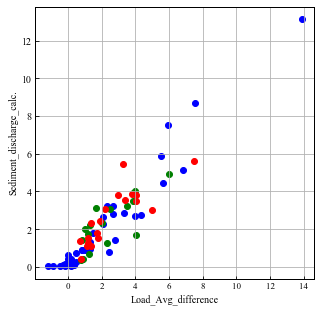

In [70]:
%matplotlib inline
print(temp[-1])
print(W_ans[-1])
W_ans[-1][0]
plt.figure(figsize=(5,5))
for i in range(len(df_event_num)):
    Y = df_event_num[i]['Load_Avg_difference'].values.reshape(len(df_event_num[i]['Load_Avg_difference']),1)
    X = df_event_num[i][names_of_data_type]
    Z = np.dot(X, W_ans[-1][1].reshape(1,10).T)
    plt.scatter(Y, Z, color=event_color_2018[i])
#     plt.xlim(0,10)
#     plt.ylim(0,10)
    plt.xlabel('Load_Avg_difference')
    plt.ylabel('Sediment_discharge_calc.')
    print(np.sum(Y), np.sum(Z))
    

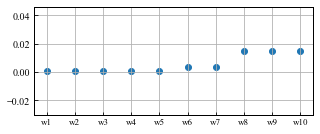

In [71]:
fig = plt.figure(figsize=(5,2))
ax = fig.add_subplot(1,1,1)
ax.scatter(['w1','w2','w3','w4','w5','w6','w7','w8','w9','w10'], W_ans[-1][1])
# ax.set_xticklabels()

[55, 53.70979701504716]
[55, array([0.00037558, 0.00037558, 0.00037558, 0.00037558, 0.00037558,
       0.00341823, 0.00341823, 0.01507843, 0.01507843, 0.01507843])]
79.95 59.25836484848485
41.0 30.581465454545455
49.29999999999998 38.326659393939394


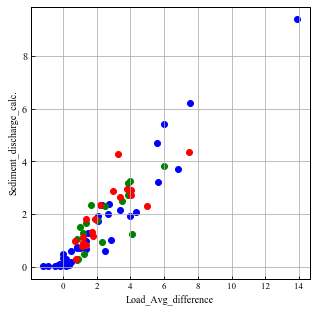

In [72]:
#実験から得られた理想値（W）を代入してグラフを書く

W_ideal = np.array([0.15, 0.22, 0.29, 0.65, 0.91, 1.96, 3.01, 3.5, 10.81, 50])*0.001

%matplotlib inline
print(temp[-1])
print(W_ans[-1])
W_ans[-1][0]
plt.figure(figsize=(5,5))
for i in range(len(df_event_num)):
    Y = df_event_num[i]['Load_Avg_difference'].values.reshape(len(df_event_num[i]['Load_Avg_difference']),1)
    X = df_event_num[i][names_of_data_type]
    Z = np.dot(X, W_ideal.reshape(1,10).T)
    plt.scatter(Y, Z, color=event_color_2018[i])
#     plt.xlim(0,10)
#     plt.ylim(0,10)
    plt.xlabel('Load_Avg_difference')
    plt.ylabel('Sediment_discharge_calc.')
    print(np.sum(Y), np.sum(Z))
    

## ピット内満砂率と捕捉率の関係を調べ、ソルバー

In [73]:
#使うcolumnデータを選択。x_nameは基本"Load_Avg_difference"
x_name = "Load_Avg_difference"
y_name = "hp_Tot(6)"
# 目的関数
def func(W):
    c = W[0]
    b = W[1]
    a = W[2]
    df_Rc = c - b*np.exp(df_12345['Load_Avg'])
    df_Qs = df_12345['Load_Avg_difference'] / df_Rc
    df_Qs = df_Qs.values.reshape(len(df_Qs),1)
    print(df_Qs.shape)
    Y = df_12345[y_name].values.reshape(len(df_12345[y_name]),1)
    Y = Y*a
    print(Y.shape)
    Cost = sum(np.power(Y-df_Qs,2))
    print(Cost)
    
#     clf = linear_model.LinearRegression(fit_intercept=False)
#     X = df_Qs.values.reshape(-1, 1)
#     Y = df_12345[y_name].values.reshape(-1, 1)
#     clf.fit(X,Y)
#     y_hat = clf.predict(X)
#     # 近似直線との誤差を計算する
#     diff = Y - y_hat
#     # 近似直線との誤差が、比較的が大きい点を無視するような、sample_weightを作成する
#     sample_weight = (np.max(np.abs(diff)) - np.abs(diff)).astype('float32').T[0] ** 2
#     # scikit-learnのsolverに、sample_weightを与えて、近似直線を得る
#     #詳しくは"https://medium.com/micin-developers/decipher-github-lr-sw-40e519a13c0a"
#     clf.fit(X, Y, sample_weight=sample_weight)
    
#     Cost = -clf.score(X, Y)
    return Cost[0]/100000

cons = ({'type': 'ineq', 'fun': lambda W: W[0]},
        {'type': 'ineq', 'fun': lambda W: W[1]},
        {'type': 'ineq', 'fun': lambda W: W[2]-0.01}
       )

times_of_try = 100
minmum_cost = 100000
temp = []
W_ans = []
results = []
for i in range(times_of_try):
    W0 = np.random.rand(1,3)# 初期値は適当
    result = minimize(func, x0=W0, constraints=cons, method="SLSQP")
    if result.fun < minmum_cost:
        minmum_cost = result.fun
        W_ans.append([i, result.x])
        temp.append([i, minmum_cost])
        results.append([i, result])
    

NameError: name 'df_12345' is not defined

In [ ]:
W_ans[-1]
print(results[-1])

In [ ]:
W = results[-1][1].x
c = W[0]
b = W[1]
df_Rc = c - b*np.exp(df_12345['Load_Avg'])
df_Qs = df_12345['Load_Avg_difference'] / df_Rc

In [ ]:
plt.figure(figsize=(5,5))
x = np.linspace(0, 1400, 100)
y = c-b * (np.exp(x))
plt.plot(x, y)
plt.show()
print(c,b)
print(y)

In [ ]:
%matplotlib inline

plt.figure(figsize=(5,5))
plt.scatter(df_Qs, df_12345[y_name])

In [74]:
def scatter_graph_in_df(df, x_name, y_name, x_range=(-2,20), y_range=(-1,7.5)):
    '''
    df :　DetaFrame
    x_name：ｘ軸に用いるパラメータの名前(str)
    y_name：ｙ軸に用いるパラメータの名前(str)
    '''
    # 「散布図行列」を作成する。散布図行列を利用すれば、データセットの特徴量のペアに対す
    # る相関関係を1 つの平面上で可視化可能
    # Notebook出力には次の１行が必要
    a, b = x_range
    c, d = y_range
    %matplotlib inline
    # Plot the data you select
    plt.figure(figsize=(8, 6))

    plt.scatter(df[x_name], df[y_name])
    plt.xlim(a, b)
    plt.ylim(c, d)

    plt.show()    

In [75]:
scatter_graph_in_df(df_cut_from000to200, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from200to400, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from400to600, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from600to800, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from800to1000, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from1000to1200, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from1200to1400, 'Load_Avg_difference', 'hp_Tot(4)')
scatter_graph_in_df(df_cut_from1400to1600, 'Load_Avg_difference', 'hp_Tot(4)')


NameError: name 'df_cut_from000to200' is not defined

In [ ]:
histgram_of_Load_Avg_difference(df_mean_30)

In [76]:
pd.options.display.max_seq_items = 200

print(df_fin.columns)

pd.options.display.max_seq_items = 20

Index(['Unnamed: 0', 'RECORD', 'Bat_Avg', 'Pit_WL_Avg', 'L_UR_Avg', 'L_UL_Avg',
       'L_DR_Avg', 'L_DL_Avg', 'Load_Avg', 'WL_FMR_Avg', 'vel_P_Tot',
       'turb1000_Avg', 'turb4000_Avg', 'DiffVolt_Avg', 'hp_Tot(1)',
       'hp_Tot(2)', 'hp_Tot(3)', 'hp_Tot(4)', 'hp_Tot(5)', 'hp_Tot(6)',
       'hp_Tot(7)', 'hp_Tot(8)', 'hp_Tot(9)', 'hp_Tot(10)', 'Unnamed: 0',
       'RECORD', 'Bat_Avg', 'outC_R_Avg', 'R_Tot(1)', 'R_Tot(2)', 'R_Tot(3)',
       'R_Tot(4)', 'R_Tot(5)', 'R_Tot(6)', 'R_Tot(7)', 'R_Tot(8)', 'R_Tot(9)',
       'R_Tot(10)', 'outC_RC_Avg', 'RC_Tot(1)', 'RC_Tot(2)', 'RC_Tot(3)',
       'RC_Tot(4)', 'RC_Tot(5)', 'RC_Tot(6)', 'RC_Tot(7)', 'RC_Tot(8)',
       'RC_Tot(9)', 'RC_Tot(10)', 'outC_C_Avg', 'C_Tot(1)', 'C_Tot(2)',
       'C_Tot(3)', 'C_Tot(4)', 'C_Tot(5)', 'C_Tot(6)', 'C_Tot(7)', 'C_Tot(8)',
       'C_Tot(9)', 'C_Tot(10)', 'outC_LC_Avg', 'LC_Tot(1)', 'LC_Tot(2)',
       'LC_Tot(3)', 'LC_Tot(4)', 'LC_Tot(5)', 'LC_Tot(6)', 'LC_Tot(7)',
       'LC_Tot(8)', 'LC_Tot(9)', 'LC_

In [77]:
#Choose data we are gonna use
#YOU SHOULD CHANGE HERE IF YOU WANNA SELECT DIFFERENT INPUT DATA OR ADD SOME DATA AS INPUTS
# y_cols = ['Load_Avg_difference']
y_cols = ['Load_Avg_difference']

#ALL
X_cols = ['Bat_Avg', 'WL_FMR_Avg', 'vel_P_Tot',
       'turb1000_Avg', 'turb4000_Avg', 'DiffVolt_Avg', 'hp_Tot(1)',
       'hp_Tot(2)', 'hp_Tot(3)', 'hp_Tot(4)', 'hp_Tot(5)', 'hp_Tot(6)',
       'hp_Tot(7)', 'hp_Tot(8)', 'hp_Tot(9)', 'hp_Tot(10)', 'outC_R_Avg', 'R_Tot(1)', 'R_Tot(2)', 'R_Tot(3)',
       'R_Tot(4)', 'R_Tot(5)', 'R_Tot(6)', 'R_Tot(7)', 'R_Tot(8)', 'R_Tot(9)',
       'R_Tot(10)', 'outC_RC_Avg', 'RC_Tot(1)', 'RC_Tot(2)', 'RC_Tot(3)',
       'RC_Tot(4)', 'RC_Tot(5)', 'RC_Tot(6)', 'RC_Tot(7)', 'RC_Tot(8)',
       'RC_Tot(9)', 'RC_Tot(10)', 'outC_C_Avg', 'C_Tot(1)', 'C_Tot(2)',
       'C_Tot(3)', 'C_Tot(4)', 'C_Tot(5)', 'C_Tot(6)', 'C_Tot(7)', 'C_Tot(8)',
       'C_Tot(9)', 'C_Tot(10)', 'outC_LC_Avg', 'LC_Tot(1)', 'LC_Tot(2)',
       'LC_Tot(3)', 'LC_Tot(4)', 'LC_Tot(5)', 'LC_Tot(6)', 'LC_Tot(7)',
       'LC_Tot(8)', 'LC_Tot(9)', 'LC_Tot(10)', 'outC_L_Avg', 'L_Tot(1)',
       'L_Tot(2)', 'L_Tot(3)', 'L_Tot(4)', 'L_Tot(5)', 'L_Tot(6)', 'L_Tot(7)',
       'L_Tot(8)', 'L_Tot(9)', 'L_Tot(10)', 'outC_VR_Avg', 'VR_Tot(1)',
       'VR_Tot(2)', 'VR_Tot(3)', 'VR_Tot(4)', 'VR_Tot(5)', 'VR_Tot(6)',
       'VR_Tot(7)', 'VR_Tot(8)', 'VR_Tot(9)', 'VR_Tot(10)', 'outC_VL_Avg',
       'VL_Tot(1)', 'VL_Tot(2)', 'VL_Tot(3)', 'VL_Tot(4)', 'VL_Tot(5)',
       'VL_Tot(6)', 'VL_Tot(7)', 'VL_Tot(8)', 'VL_Tot(9)', 'VL_Tot(10)',
       'outC_VC_Avg', 'VC_Tot(1)', 'VC_Tot(2)', 'VC_Tot(3)', 'VC_Tot(4)',
       'VC_Tot(5)', 'VC_Tot(6)', 'VC_Tot(7)', 'VC_Tot(8)', 'VC_Tot(9)',
       'VC_Tot(10)', 'outC_T75_Avg', 'T75_Tot(1)', 'T75_Tot(2)', 'T75_Tot(3)',
       'T75_Tot(4)', 'T75_Tot(5)', 'T75_Tot(6)', 'T75_Tot(7)', 'T75_Tot(8)',
       'T75_Tot(9)', 'T75_Tot(10)', 'outC_Plate_Avg', 'Plate_Tot(1)',
       'Plate_Tot(2)', 'Plate_Tot(3)', 'Plate_Tot(4)', 'Plate_Tot(5)',
       'Plate_Tot(6)', 'Plate_Tot(7)', 'Plate_Tot(8)', 'Plate_Tot(9)',
       'Plate_Tot(10)', 'Vib_Avg']

X = df_fin[X_cols]
y = df_fin[y_cols]
# #     X.rolling(window=5).mean()
#     y.rolling(window=5).mean()



In [78]:
# print(X)

In [79]:
#Cut data where pit weigh < 1000?500?
df_fin['Load_Avg'] = df_fin['Load_Avg'].values.astype('float')
df_cut1 = df_fin[(df_fin['Load_Avg'] > 200)&(df_fin['Load_Avg'] < 1300)]

# Cut data where pit load difference is out of margin of error
df_cut2 = df_cut1[(df_cut1['Load_Avg_difference'] < 20)&(df_cut1['Load_Avg_difference'] > -0.5)]

ValueError: could not broadcast input array from shape (3805) into shape (3)

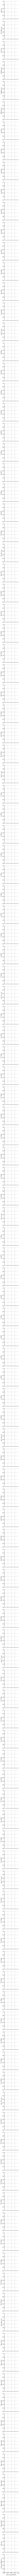

In [80]:
# 「散布図行列」を作成する。散布図行列を利用すれば、データセットの特徴量のペアに対す
# る相関関係を1 つの平面上で可視化可能
import matplotlib.pyplot as plt
import seaborn as sns
Xy_cols = X_cols + y_cols
df_f = df_cut2[Xy_cols].astype('float')
sns.pairplot(df_f[Xy_cols],x_vars=['Load_Avg_difference'], y_vars= Xy_cols, height=2.5)

#グラフを保存するときは描画させない
plt.show()
# plt.savefig('figure(LADandOthers).png')

In [ ]:
# df_cut3 = df_cut2.set_index('TIMESTAMP')

fig, ax1 = plt.subplots()

#x軸
s=df_cut2.index

#主軸に出来高の棒グラフ
ax1.bar(s,df_cut2['hp_Tot(1)'], color = 'g')

#主軸と2軸の関連づけ
ax2=ax1.twinx()

#第2軸に株価
ax2.plot(s,df_cut2['Rainfall'],'r', label = 'pulses')

# 描画の調整
plt.rcParams['font.size'] = 8
plt.ylabel('Number_of_pulses')
plt.legend()
plt.savefig('compiration_LADandHP(1).png')
plt.show()

In [ ]:
X = df_cut2[X_cols].values.astype('float')
y = df_cut2[y_cols].values.astype('float')

In [ ]:
#Devide data into Training set and test set
#In Machine Learning course of coursera, I learned that I have to devide the data set into Training set, Cross calidation set,Test set.
#But in this case I'll just follow the code that I found online. Probably I'll have to fix this part once I get to know much more about Machine Learning.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_ori_train = X_train
X_ori_test = X_test
y_ori_train = y_train
y_ori_test = y_test

In [ ]:
# train the parameters with regression model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(100)
# n_estimators : integer, optional (default=10)
# The number of trees in the forest.

model.fit(X_train, y_train.ravel())

In [ ]:
#Score
#coefficient of determination R^2 

print(model.score(X_test,y_test))

In [ ]:
# #Score without the data where there's no events happning
#Delete data of when the pit gets cleared 

df_y_test = pd.DataFrame(y_test)
df_y_test.columns = y_cols
df_X_test = pd.DataFrame(X_test)
df_X_test.columns = X_cols

df_yX_test = pd.concat([df_y_test, df_X_test], axis=1)

df_yX_test_del = df_yX_test[(df_yX_test['Load_Avg_difference'] < 20)&(df_yX_test['Load_Avg_difference'] > 1)]
X_test_del = df_yX_test_del[X_cols].values.astype('float')
y_test_del = df_yX_test_del[y_cols].values.astype('float')


print("Score ,when y>1")
print(model.score(X_test_del,y_test_del))
print("The number of the data where y > 1 ", "is " ,len(y_test_del))

In [ ]:
# y, X should be real data. X is gonna put into the model you made 
# and the model will give you the predictions. 
# This line graph shows how the predicitons match with the real data which is y.
# Second gragh zooms out the part where you chose from sta to end.
class Graph:
    def __init__(self, y, X):
        self.y = y
        self.X = X
        

    def line_graph(self, sta = 0, end = len(y)):
        result = model.predict(self.X)
        #flatten y_test to applay the data to a graph
        y_graph = self.y.flatten()
        #
        df_result = pd.DataFrame({"y_test":y_graph,"result":result})

        #
        %matplotlib inline
        import matplotlib
        import matplotlib.pyplot as plt

        # Draw graph
        df_result.plot(figsize=(15, 3))
        
        # Zoom out where you chose
        df_result[sta:end].plot(figsize=(15, 3))
        plt.show()
        
    def cumlate_graph(self, sta = 0, end = len(y)):
        result = model.predict(self.X)

        p_res = np.cumsum(result)
        y_res = np.cumsum(self.y)

        %matplotlib inline
        import matplotlib
        import matplotlib.pyplot as plt

        df_p_x = pd.DataFrame({"original":y_res,"result":p_res})
        df_p_x.plot(figsize=(15, 3))
        df_p_x[sta:end].plot(figsize=(15, 3))
        plt.show()

        
    #Take a look at a distribution map between y and X
    def distribution_map(self, number = 0):
        import matplotlib.pyplot as plt
        # Notebook出力には次の１行が必要
        %matplotlib inline

        # # Plot the data you select
        plt.figure(figsize=(8, 6))

        plt.scatter(self.y, self.X[:,number])
        plt.show()

        
    


In [ ]:
# Graphs of test data

yX_test = Graph(y_test,X_test)
yX_test.line_graph()
for i in range(len(X_cols)):
    yX_test.distribution_map(i)
yX_test.cumlate_graph()

In [ ]:
yX_all = Graph(y, X)
yX_all.line_graph()
# yX_all.cumlate_graph(90000,100000)
# for i in range(len(X_cols)):
#     yX_all.distribution_map(i)
#     print(X_cols[i])

In [ ]:
yX_all = Graph(y, X)
yX_all.line_graph()

In [ ]:
yX_test_del = Graph(y_test_del, X_test_del)
yX_test_del.distribution_map(3)
yX_test_del.cumlate_graph()
yX_test_del.line_graph()

In [ ]:
df_ori = df_new[(df_new['hp_Tot(6)'] > -10)&(df_new['hp_Tot(6)'] < 500)]

X_ori = df_ori[X_cols].values.astype('float')
y_ori = df_ori[y_cols].values.astype('float')


yX_ori = Graph(y_ori, X_ori)
yX_ori.cumlate_graph()


In [ ]:
#
feature = model.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.loc[:, 'number']

#Name of the features
dfX = pd.DataFrame(X)
dfX.columns = X_cols
label = dfX.columns[0:]

#arrange the features in order of importance
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print( str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

          
import matplotlib
import matplotlib.pyplot as plt
plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.datasets import *
# from sklearn import tree
# from dtreeviz.trees import *
# import graphviz

In [ ]:
# from sklearn.datasets import *
# from sklearn import tree
# from dtreeviz.trees import *

# X_cols_np = np.array(X_cols)

# regr = tree.DecisionTreeRegressor(max_depth=10)
# regr.fit(X_train, y_train.ravel())

# viz = dtreeviz(regr,
#                X_train,
#                y_train.ravel(),
#                target_name="",
#                feature_names= X_cols_np
#               )

# #There's a UnicodeDecodeError problem if you try to visualize "viz",which is caused by the Japanese setting of this computer.
# #"viz.view()" works fine on Ubuntu in my Virtual machine.
# # viz.view()

In [ ]:
# print(regr.score(X_test,y_test))

# 使用メモリ確認

In [ ]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
        
#もし消したいメモリがあれば
# del ～～～